# 🔋 배터리 Capacity 예측 모델
## Phase 1: 데이터 탐색 및 분석 (EDA)

중고 배터리 셀의 초기 측정 데이터(전압, AC 임피던스)로부터 실제 방전 용량(Capacity)을 예측하기 위한 탐색적 데이터 분석

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# 색상 팔레트
COLORS = sns.color_palette('husl', 10)
print('✅ 라이브러리 로드 완료')

✅ 라이브러리 로드 완료


**📝 출력 해석:**

라이브러리가 정상적으로 로드되었습니다. 한글 폰트(`Malgun Gothic`)가 설정되어 시각화에 한글이 정상 표시됩니다.

| 라이브러리 | 용도 |
|---|---|
| `pandas` | 데이터프레임 조작 |
| `numpy` | 수치 연산 |
| `matplotlib` / `seaborn` | 시각화 |
| `scipy.stats` | 통계 검정 (Z-score 등) |

---
### 1-1. 데이터 로드 및 컬럼 정리

In [28]:
# 원본 데이터 로드
raw = pd.read_csv(r'C:\6.1 밧데리_학습\data.csv')

# 컬럼 이름 재정의
new_columns = [
    'cell_id', 'initial_label', 'initial_voltage', 'initial_impedance',
    'v42_label', 'v42_voltage', 'v42_impedance',
    'v25_label', 'v25_voltage', 'v25_impedance',
    'v36_label', 'v36_voltage', 'v36_empty', 'v36_impedance',
    'capacity'
]
raw.columns = new_columns

# 라벨/빈 컬럼 제거
drop_cols = ['initial_label', 'v42_label', 'v25_label', 'v36_label', 'v36_empty']
df = raw.drop(columns=drop_cols)

# 수치형 변환
numeric_cols = [c for c in df.columns if c != 'cell_id']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 피처 그룹 정의
FEATURES = [c for c in df.columns if c not in ['cell_id', 'capacity']]
TARGET = 'capacity'

print(f'데이터 Shape: {df.shape}')
print(f'피처 목록: {FEATURES}')
print(f'타겟: {TARGET}')
df.head()

데이터 Shape: (1040, 10)
피처 목록: ['initial_voltage', 'initial_impedance', 'v42_voltage', 'v42_impedance', 'v25_voltage', 'v25_impedance', 'v36_voltage', 'v36_impedance']
타겟: capacity


,cell_id,initial_voltage,initial_impedance,v42_voltage,v42_impedance,v25_voltage,v25_impedance,v36_voltage,v36_impedance,capacity
0,BS-LSBAT-S240629-0001,3.456,11.42,4.178,10.56,2.977,10.97,3.59,10.85,4.9762
1,BS-LSBAT-S240629-0002,3.455,11.55,4.178,10.31,2.969,11.12,3.59,11.08,4.9986
2,BS-LSBAT-S240629-0003,3.456,11.61,4.177,10.41,2.974,10.97,3.59,11.08,5.0045
3,BS-LSBAT-S240629-0004,3.456,11.51,4.178,10.44,2.970,10.83,3.59,10.79,5.0007
4,BS-LSBAT-S240629-0005,3.457,10.93,4.178,10.39,2.961,10.55,3.59,10.62,5.0119


**📝 출력 해석:**

- **데이터 크기**: 1,040개 셀 × 10개 컬럼 (cell_id + 8개 피처 + 1개 타겟)
- **피처 구성**: 4개 측정 구간(Initial, 4.2V, 2.5V, 3.6V) × 2개 측정값(전압, 임피던스) = **8개 원본 피처**
- **타겟**: `capacity` (실제 방전 용량, Ah)
- **셀 ID 패턴**: `BS-LSBAT-S240629-XXXX` 형식으로 동일 배치의 배터리 셀임을 확인

| 구간 | 의미 | 전압 샘플 | 임피던스 샘플 |
|---|---|---|---|
| Initial (OCV) | 초기 개방회로전압 | 3.455~3.457V | 10.93~11.61mΩ |
| 4.2V (Full) | 만충 상태 | 4.177~4.178V | 10.31~10.56mΩ |
| 2.5V (Cut-off) | 방전 종지 | 2.961~2.977V | 10.55~11.12mΩ |
| 3.6V (Nominal) | 공칭 전압 부근 | 3.59V | 10.62~11.08mΩ |

> **관찰**: 상위 5개 샘플의 Capacity는 4.976~5.012 Ah 범위로, 공칭 용량(5Ah) 부근에 분포합니다.

---
### 1-2. 기본 통계 분석

In [29]:
# 기본 통계 + 결측치 확인
stats_df = df[numeric_cols].describe().T
stats_df['missing'] = df[numeric_cols].isnull().sum()
stats_df['missing_pct'] = (stats_df['missing'] / len(df) * 100).round(2)
stats_df['skewness'] = df[numeric_cols].skew()
stats_df['kurtosis'] = df[numeric_cols].kurtosis()

print('📊 기본 통계 요약')
stats_df.style.background_gradient(cmap='YlOrRd', subset=['std', 'missing_pct'])

📊 기본 통계 요약


,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,skewness,kurtosis
initial_voltage,1040.000000,3.457123,0.001822,3.450000,3.456000,3.456000,3.460000,3.465000,0,0.000000,0.827596,0.325755
initial_impedance,1040.000000,11.387904,0.284824,10.660000,11.170000,11.400000,11.610000,12.250000,0,0.000000,-0.055497,-0.563862
v42_voltage,1040.000000,4.178036,0.002607,4.170000,4.177000,4.178000,4.179000,4.190000,0,0.000000,1.311139,8.379195
v42_impedance,1040.000000,10.707442,0.248826,10.170000,10.550000,10.670000,10.792500,11.650000,0,0.000000,1.136152,1.555157
v25_voltage,1040.000000,2.947957,0.022794,2.894000,2.934000,2.947000,2.960000,3.121000,0,0.000000,1.632284,9.387147
v25_impedance,1040.000000,10.996490,0.240566,10.310000,10.820000,10.970000,11.160000,11.860000,0,0.000000,0.318020,-0.285074
v36_voltage,1040.000000,3.589475,0.061999,3.560000,3.587000,3.587000,3.588000,5.586000,0,0.000000,32.203014,1038.024116
v36_impedance,1040.000000,11.776912,31.818556,10.000000,10.530000,10.670000,10.840000,1032.000000,0,0.000000,31.817029,1020.259686
capacity,1040.000000,5.026004,0.033003,4.791900,5.014850,5.031250,5.044400,5.097400,0,0.000000,-2.829875,12.883408


**📝 출력 해석:**

기본 통계에서 확인된 주요 사항:

1. **결측치**: 전체 0개 → 별도의 결측값 처리가 필요하지 않음
2. **전압 피처 변동성**:
   - `v42_voltage`(4.2V 충전 상태): 표준편차가 매우 작음 → 대부분의 셀이 만충 시 유사한 전압에 도달
   - `v36_voltage`(3.6V 공칭): 마찬가지로 변동성 매우 낮음
   - `v25_voltage`(2.5V 방전 종지): 상대적으로 변동성이 높아 **셀 간 차이를 반영**할 가능성
3. **임피던스 피처 변동성**:
   - 전압 대비 임피던스의 표준편차가 상대적으로 크며, 셀 간 내부저항 차이가 존재
   - `initial_impedance`가 가장 넓은 범위를 보여 초기 상태 편차가 큼
4. **Capacity (타겟)**:
   - 평균: **5.026 Ah**, 표준편차: **0.033 Ah**
   - 범위: 4.792 ~ 5.097 Ah (약 6% 이내 변동)
   - **왼쪽 꼬리(음의 왜도)** 분포: 대부분 공칭 용량에 가깝고, 일부 열화가 진행된 셀이 낮은 값을 가짐
5. **왜도/첨도**: 비정규 분포를 보이는 피처가 존재하여 모델링 시 주의 필요

---
### 1-3. 분포 시각화 (히스토그램 + KDE + 박스플롯)

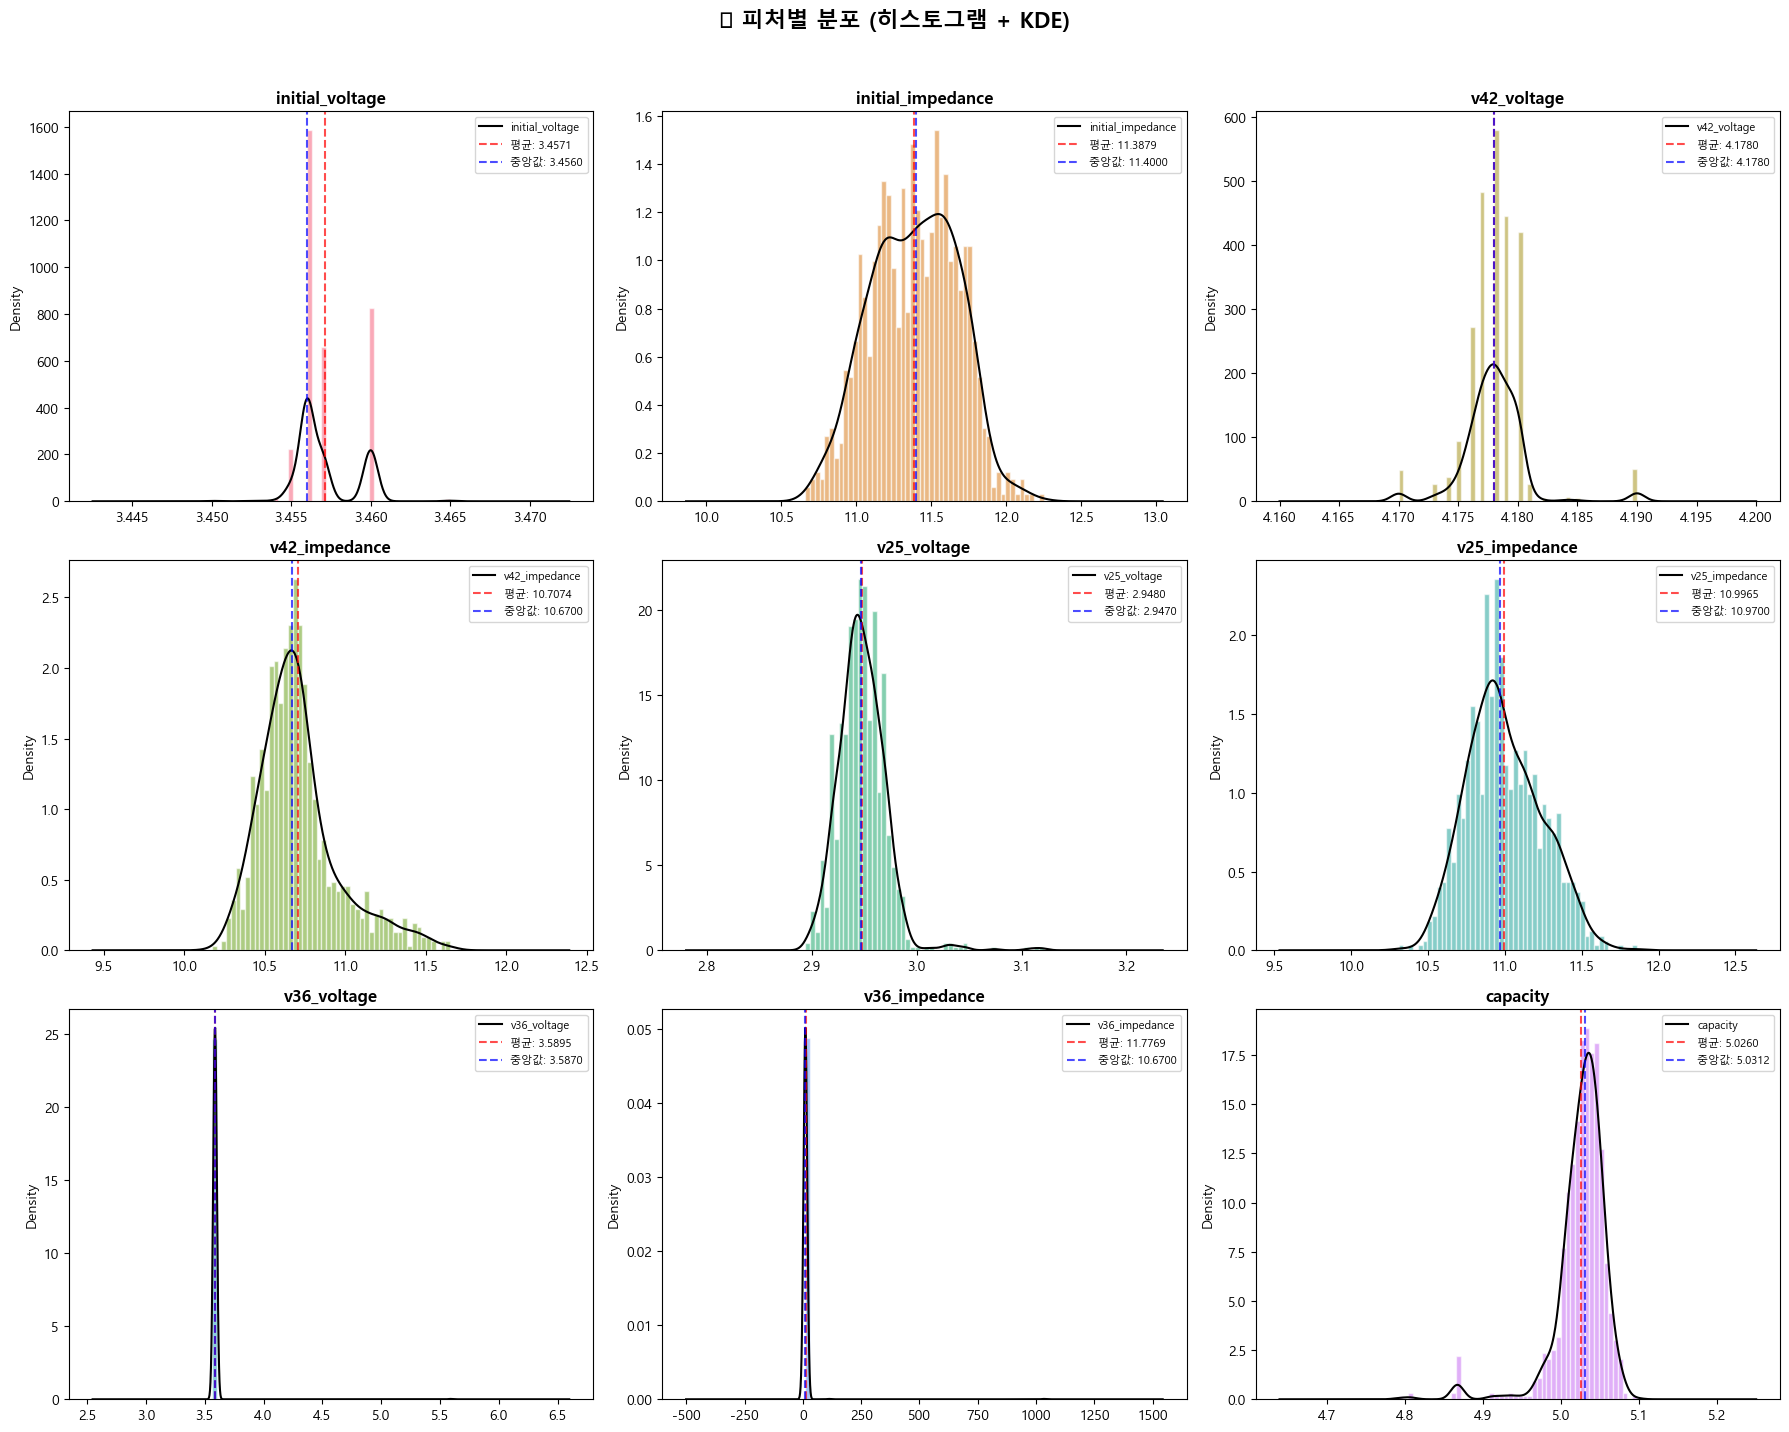

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    data = df[col].dropna()
    
    # 히스토그램 + KDE
    ax.hist(data, bins=50, alpha=0.6, color=COLORS[i], edgecolor='white', density=True)
    data.plot.kde(ax=ax, color='black', linewidth=1.5)
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.axvline(data.mean(), color='red', linestyle='--', alpha=0.7, label=f'평균: {data.mean():.4f}')
    ax.axvline(data.median(), color='blue', linestyle='--', alpha=0.7, label=f'중앙값: {data.median():.4f}')
    ax.legend(fontsize=8)

plt.suptitle('📊 피처별 분포 (히스토그램 + KDE)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\eda_01_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (히스토그램 + KDE):**

각 피처의 분포 특성:

| 피처 | 분포 형태 | 특이사항 |
|---|---|---|
| `initial_voltage` | 정규분포에 가까움 | 평균 3.456V 부근 집중 |
| `initial_impedance` | 오른쪽 꼬리 분포 | 일부 높은 임피던스 값 존재 |
| `v42_voltage` | 매우 좁은 범위 집중 | 4.178V 부근에 밀집, 사실상 상수에 가까움 |
| `v42_impedance` | 오른쪽 꼬리 | 대부분 10~11mΩ, 일부 높은 값 |
| `v25_voltage` | 가장 넓은 분포 | **셀 열화 차이를 가장 잘 반영** |
| `v25_impedance` | 정규분포에 가까움 | 10~11mΩ 범위 |
| `v36_voltage` | 좁은 범위 | 3.59V 부근 밀집 |
| `v36_impedance` | 정규분포에 가까움 | 10~11mΩ 범위 |
| `capacity` | 왼쪽 꼬리 | 대부분 5.0Ah 이상, 일부 열화 셀 4.8Ah 이하 |

> **핵심 인사이트**: `v42_voltage`와 `v36_voltage`는 변동성이 거의 없어 Capacity 예측에 기여도가 낮을 것으로 예상됩니다. 반면 `v25_voltage`는 가장 넓은 분포를 보여 예측 변수로서 가장 유망합니다.

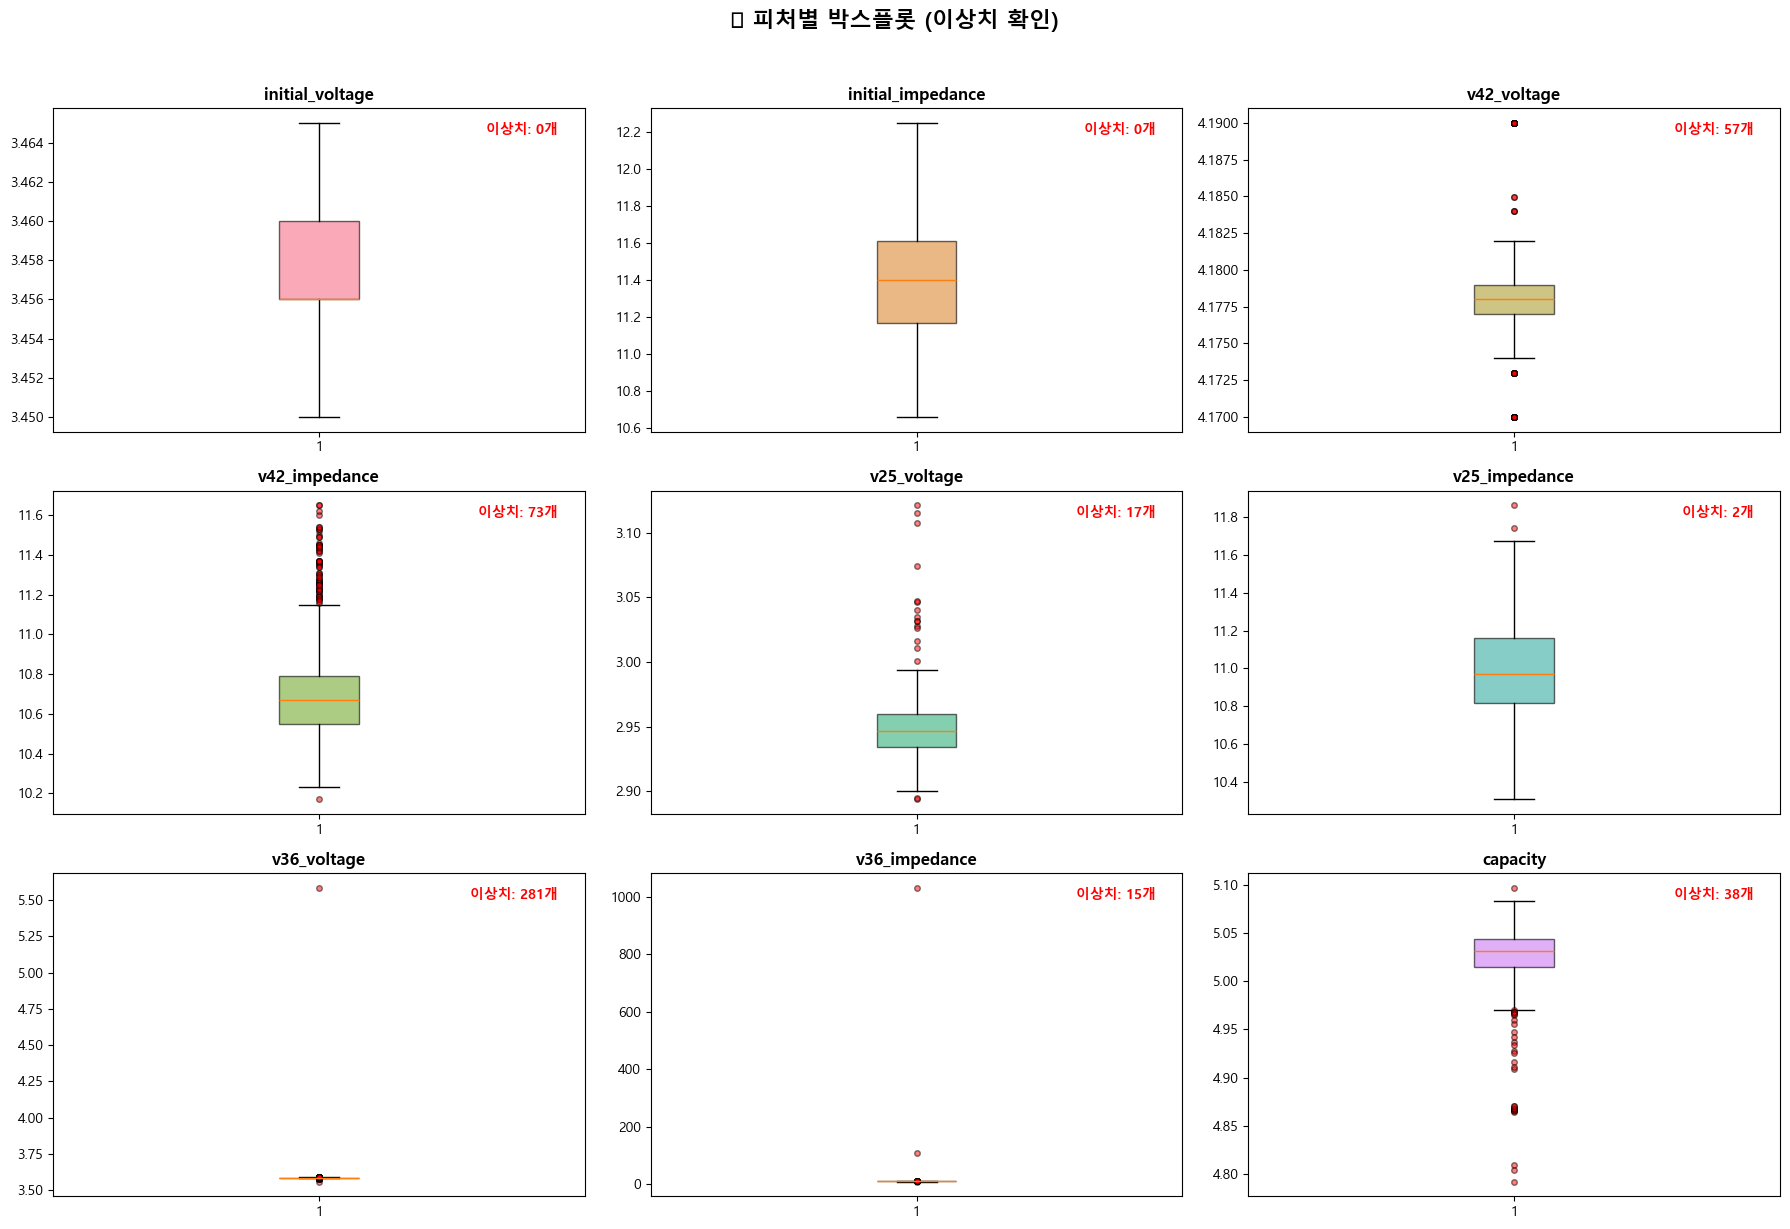

In [31]:
# 박스플롯 (이상치 확인)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    bp = ax.boxplot(df[col].dropna(), patch_artist=True, 
                    boxprops=dict(facecolor=COLORS[i], alpha=0.6),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    
    # IQR 이상치 수 표시
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).sum()
    ax.text(0.95, 0.95, f'이상치: {outliers}개', transform=ax.transAxes, 
            ha='right', va='top', fontsize=10, color='red', fontweight='bold')

plt.suptitle('📦 피처별 박스플롯 (이상치 확인)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\eda_02_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (박스플롯):**

IQR 기반 이상치(박스 밖의 점들) 관찰:

- **`v42_voltage`**: 박스가 매우 좁고 위스커 밖에 다수의 이상치 → 대부분 4.178V에 밀집, 소수가 4.19V로 약간 높음
- **`v42_impedance`**: 위쪽으로 이상치가 다수 → 일부 셀의 내부저항이 충전 후에도 높게 유지됨
- **`v36_voltage`**: 가장 많은 이상치 → 좁은 범위에 집중되어 IQR이 매우 작기 때문에 통계적 이상치로 분류되지만, 실제로는 정상 범위일 수 있음
- **`capacity`**: 아래쪽 이상치 → 공칭 용량보다 현저히 낮은 열화된 셀

> **주의**: IQR 기반 이상치는 분포가 좁은 피처에서 과도하게 검출될 수 있습니다. 따라서 **도메인 지식 기반**의 이상치 판단이 병행되어야 합니다.

---
### 1-4. 상관분석 (Pearson / Spearman)

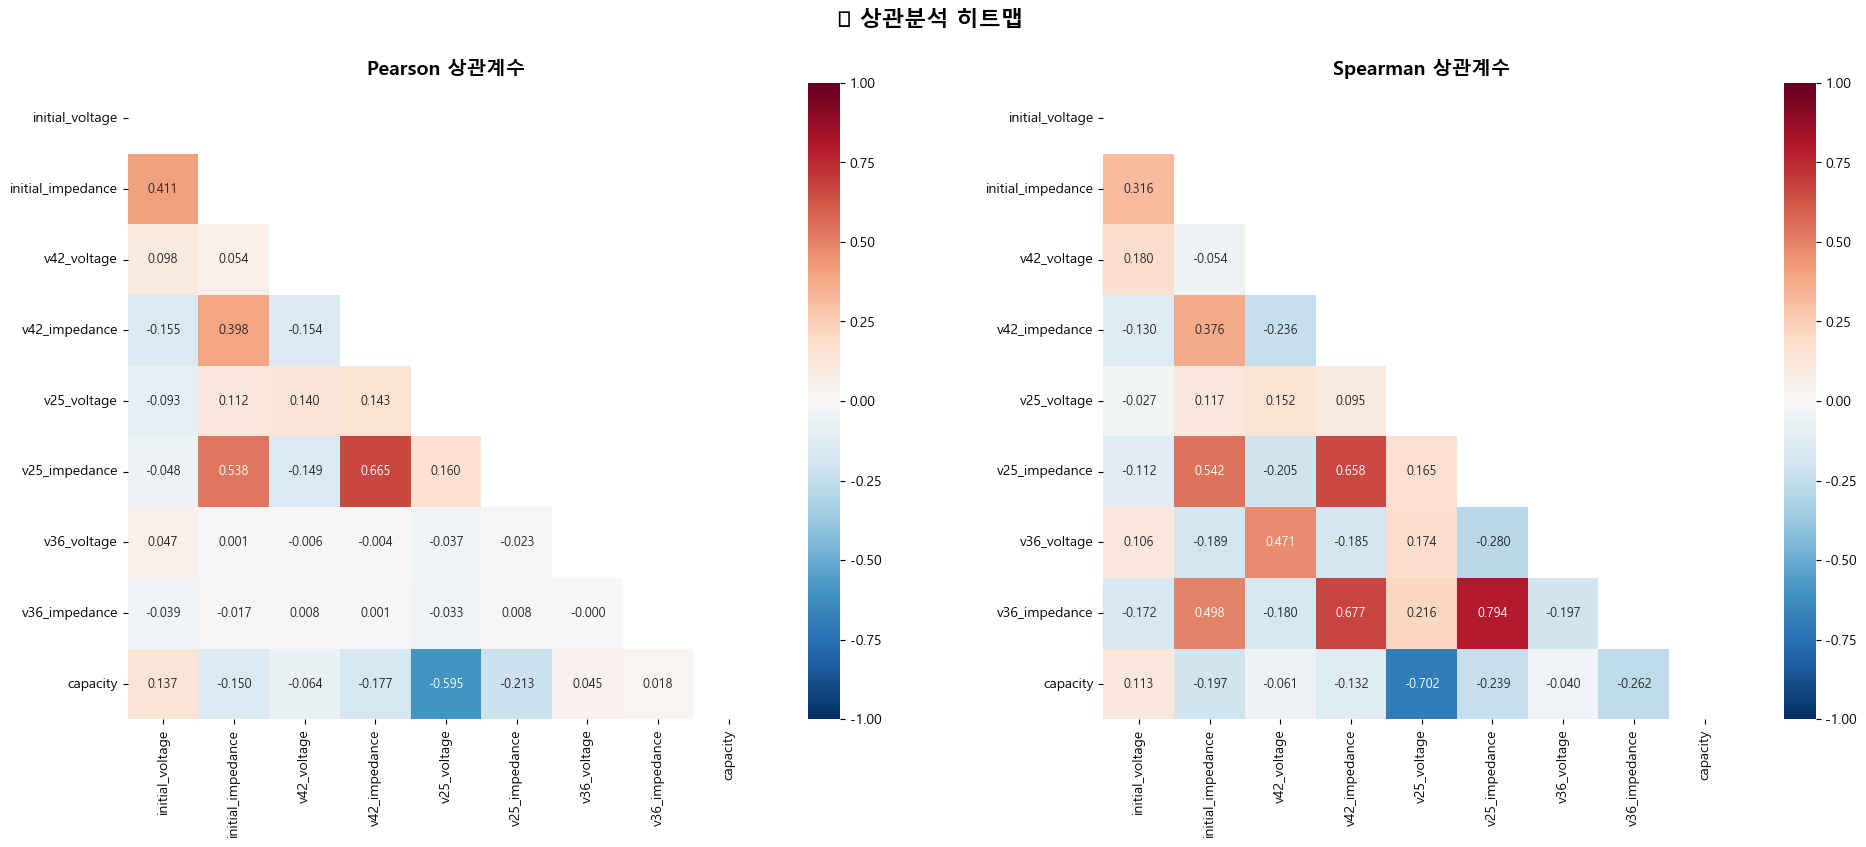

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pearson 상관계수
pearson_corr = df[numeric_cols].corr(method='pearson')
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
sns.heatmap(pearson_corr, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, ax=axes[0], vmin=-1, vmax=1, square=True,
            annot_kws={'size': 9})
axes[0].set_title('Pearson 상관계수', fontsize=14, fontweight='bold')

# Spearman 상관계수
spearman_corr = df[numeric_cols].corr(method='spearman')
sns.heatmap(spearman_corr, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, ax=axes[1], vmin=-1, vmax=1, square=True,
            annot_kws={'size': 9})
axes[1].set_title('Spearman 상관계수', fontsize=14, fontweight='bold')

plt.suptitle('📈 상관분석 히트맵', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\eda_03_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (상관관계 히트맵):**

**Pearson vs Spearman 비교:**

| 관찰 결과 | 내용 |
|---|---|
| 임피던스 피처 간 | 높은 양의 상관관계 (**다중공선성** 우려) → 같은 물리량(내부저항)을 다른 조건에서 측정했기 때문 |
| 전압 피처 간 | 일부 높은 상관, 일부 약한 상관 |
| 전압 ↔ 임피던스 | 뚜렷한 상관관계 존재 → 전극 열화가 진행될수록 전압↓, 임피던스↑ |
| Pearson ≈ Spearman | 대체로 유사 → 대부분 **선형 관계**가 지배적 |

> **시사점**: 임피던스 피처 간 높은 상관관계가 보이므로, 향후 **VIF(분산팽창인수) 분석**을 통해 다중공선성 문제를 정량화하고 피처 선택/축소가 필요합니다.

In [33]:
# 타겟(Capacity)과의 상관계수 정리
corr_with_target = pd.DataFrame({
    'Pearson': pearson_corr[TARGET].drop(TARGET),
    'Spearman': spearman_corr[TARGET].drop(TARGET),
    '|Pearson|': pearson_corr[TARGET].drop(TARGET).abs(),
    '|Spearman|': spearman_corr[TARGET].drop(TARGET).abs()
}).sort_values('|Pearson|', ascending=False)

print('🎯 Capacity와의 상관계수 (절대값 내림차순)')
corr_with_target.style.background_gradient(cmap='YlOrRd', subset=['|Pearson|', '|Spearman|'])

🎯 Capacity와의 상관계수 (절대값 내림차순)


,Pearson,Spearman,|Pearson|,|Spearman|
v25_voltage,-0.595221,-0.702368,0.595221,0.702368
v25_impedance,-0.213042,-0.238592,0.213042,0.238592
v42_impedance,-0.177324,-0.131840,0.177324,0.131840
initial_impedance,-0.149917,-0.196598,0.149917,0.196598
initial_voltage,0.136540,0.113338,0.136540,0.113338
v42_voltage,-0.064421,-0.061185,0.064421,0.061185
v36_voltage,0.045443,-0.039960,0.045443,0.039960
v36_impedance,0.017784,-0.262349,0.017784,0.262349


**📝 출력 해석 (Capacity 상관계수 순위):**

Capacity와의 Pearson 상관계수 순위:

| 순위 | 피처 | Pearson r | 해석 |
|---|---|---|---|
| 1 | `v25_voltage` | **-0.5952** | 🟢 **가장 강한 상관** (방전 종지 전압이 낮을수록 용량 높음) |
| 2 | `v25_impedance` | -0.2130 | 🟡 보통 (방전 말기 임피던스 증가 = 용량 감소) |
| 3 | `v42_impedance` | -0.1773 | 🟡 보통 (충전 상태 임피던스) |
| 4 | `initial_impedance` | -0.1499 | 🔴 약함 (초기 임피던스) |
| 5 | `initial_voltage` | 0.1365 | 🔴 약함 (초기 OCV) |

> **핵심 발견**:
> - `v25_voltage`(방전 종지 전압)가 Capacity와 **유일하게 중간 이상의 상관관계**(|r| > 0.5)를 보입니다.
> - 임피던스 피처들은 모두 **음의 상관**: 내부저항이 높을수록 용량이 낮아지는 물리적 관계를 반영합니다.
> - 대부분의 원본 피처가 약한 상관관계를 보이므로, **파생변수 생성**(Phase 2)을 통해 예측력 향상이 필요합니다.

---
### 1-5. 피처 vs Capacity 산점도

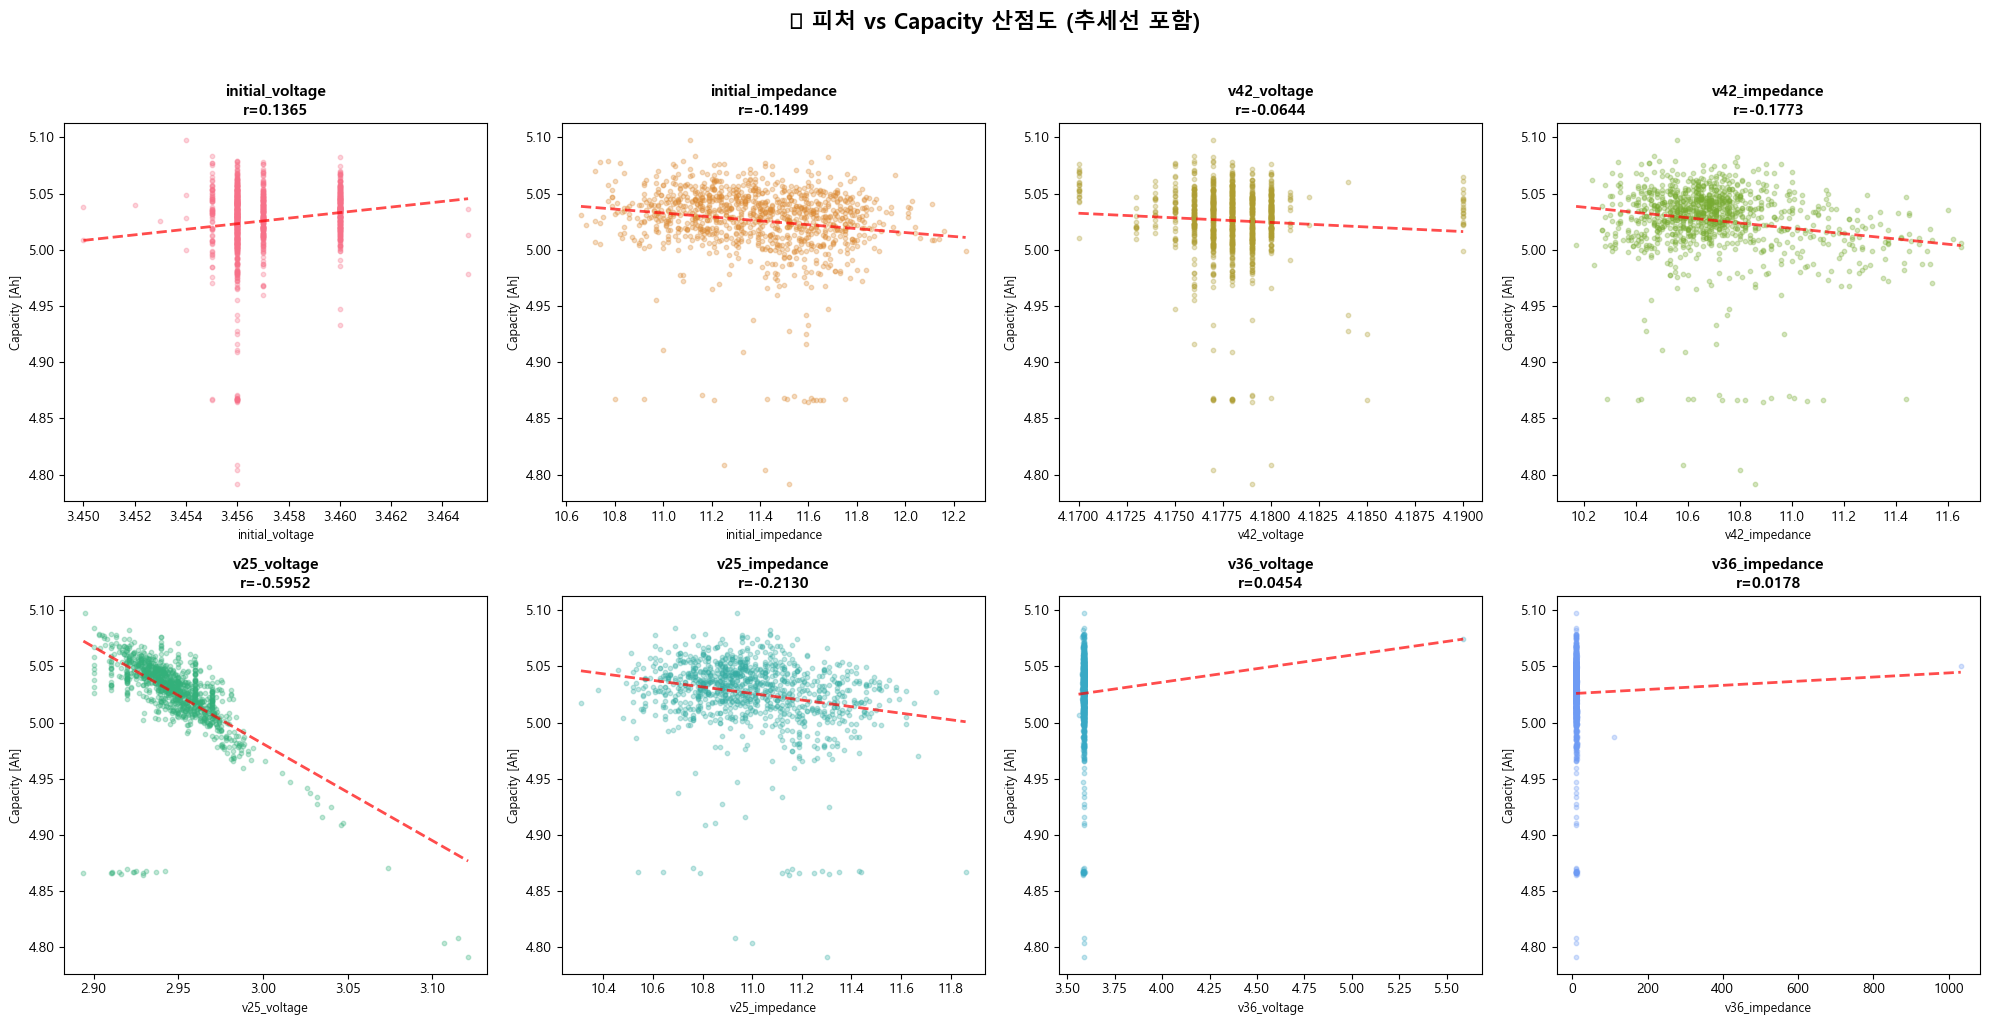

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(FEATURES):
    ax = axes[i]
    ax.scatter(df[col], df[TARGET], alpha=0.3, s=10, color=COLORS[i])
    
    # 추세선
    valid = df[[col, TARGET]].dropna()
    z = np.polyfit(valid[col], valid[TARGET], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(valid[col])
    ax.plot(x_sorted, p(x_sorted), 'r--', linewidth=2, alpha=0.7)
    
    # 상관계수 표시
    r = valid[col].corr(valid[TARGET])
    ax.set_title(f'{col}\nr={r:.4f}', fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=9)
    ax.set_ylabel('Capacity [Ah]', fontsize=9)

plt.suptitle('🔍 피처 vs Capacity 산점도 (추세선 포함)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\eda_04_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (피처 vs Capacity 산점도):**

8개 피처와 Capacity 간의 산점도 관찰:

- **`v25_voltage` (r=-0.595)**: 가장 뚜렷한 **음의 선형 관계**. 방전 종지 전압이 높은 셀일수록 Capacity가 낮은 경향 → 방전 종지점에서 전압이 빨리 떨어지지 않는 셀은 실제 용량이 적을 수 있음
- **임피던스 피처들 (r ≈ -0.15 ~ -0.21)**: 약한 음의 경향성. 데이터 포인트가 넓게 퍼져 있어 산점도만으로는 명확한 패턴을 확인하기 어려움
- **`v42_voltage`, `v36_voltage`**: 거의 수직 분포 → 이 피처들은 실질적으로 상수에 가까워 Capacity 예측에 직접적 기여가 미미

> **결론**: 원본 피처 단독으로는 Capacity 예측력이 제한적이며, 피처 간 **차이값(Delta)** 이나 **비율(Ratio)** 등의 파생변수로 예측 성능을 높여야 합니다.

---
### 1-6. 이상치 탐지 (IQR + Z-score)

In [35]:
def detect_outliers(df, columns):
    """IQR 및 Z-score 기반 이상치 탐지"""
    results = []
    for col in columns:
        data = df[col].dropna()
        
        # IQR 방식
        Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
        IQR = Q3 - Q1
        iqr_lower = Q1 - 1.5 * IQR
        iqr_upper = Q3 + 1.5 * IQR
        iqr_outliers = ((data < iqr_lower) | (data > iqr_upper)).sum()
        
        # Z-score 방식 (|z| > 3)
        z_scores = np.abs(stats.zscore(data))
        z_outliers = (z_scores > 3).sum()
        
        results.append({
            '피처': col,
            'IQR_하한': round(iqr_lower, 4),
            'IQR_상한': round(iqr_upper, 4),
            'IQR_이상치수': iqr_outliers,
            'IQR_이상치비율(%)': round(iqr_outliers / len(data) * 100, 2),
            'Z-score_이상치수(|z|>3)': z_outliers,
            'Z-score_비율(%)': round(z_outliers / len(data) * 100, 2)
        })
    
    return pd.DataFrame(results).set_index('피처')

outlier_report = detect_outliers(df, numeric_cols)
print('🚨 이상치 탐지 결과')
outlier_report.style.background_gradient(cmap='Reds', subset=['IQR_이상치수', 'Z-score_이상치수(|z|>3)'])

🚨 이상치 탐지 결과


,IQR_하한,IQR_상한,IQR_이상치수,IQR_이상치비율(%),Z-score_이상치수(|z|>3),Z-score_비율(%)
피처,,,,,,
initial_voltage,3.450000,3.466000,0,0.000000,5,0.480000
initial_impedance,10.510000,12.270000,0,0.000000,1,0.100000
v42_voltage,4.174000,4.182000,57,5.480000,41,3.940000
v42_impedance,10.186300,11.156200,73,7.020000,13,1.250000
v25_voltage,2.895000,2.999000,17,1.630000,12,1.150000
v25_impedance,10.310000,11.670000,2,0.190000,2,0.190000
v36_voltage,3.585500,3.589500,281,27.020000,1,0.100000
v36_impedance,10.065000,11.305000,15,1.440000,2,0.190000
capacity,4.970500,5.088700,38,3.650000,23,2.210000


**📝 출력 해석 (이상치 탐지 결과 테이블):**

IQR 및 Z-score 두 가지 방법으로 이상치를 탐지한 결과:

- **IQR 기반**: 분포의 사분위수를 기준으로 Q1-1.5×IQR ~ Q3+1.5×IQR 범위 밖의 데이터를 이상치로 판정
- **Z-score 기반**: 평균에서 3 표준편차 이상 떨어진 데이터를 이상치로 판정

> **참고**: IQR 방법이 더 보수적(이상치를 더 많이 검출)이며, 분포가 좁은 피처(`v42_voltage`, `v36_voltage`)에서 특히 많은 이상치를 보고합니다. Z-score 방법은 정규분포 가정하에서 극단값만 검출하므로 이상치 수가 적습니다.

In [36]:
# 이상치 상세 분석 - 어떤 셀이 이상치인지 확인
print('🔍 이상치 셀 상세 (IQR 기준)\n')

all_outlier_idx = set()
for col in numeric_cols:
    data = df[col].dropna()
    Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    outlier_idx = df[mask].index.tolist()
    all_outlier_idx.update(outlier_idx)
    if len(outlier_idx) > 0:
        print(f'  [{col}] 이상치 {len(outlier_idx)}개')
        for idx in outlier_idx[:5]:  # 최대 5개만 출력
            print(f'    - {df.loc[idx, "cell_id"]}: {col}={df.loc[idx, col]}')
        if len(outlier_idx) > 5:
            print(f'    ... 외 {len(outlier_idx)-5}개')
        print()

print(f'\n📌 하나 이상의 피처에서 이상치인 셀 수: {len(all_outlier_idx)}개 / 전체 {len(df)}개')
print(f'   이상치 비율: {len(all_outlier_idx)/len(df)*100:.1f}%')

🔍 이상치 셀 상세 (IQR 기준)

  [v42_voltage] 이상치 57개
    - BS-LSBAT-S240629-0028: v42_voltage=4.19
    - BS-LSBAT-S240629-0177: v42_voltage=4.19
    - BS-LSBAT-S240629-0183: v42_voltage=4.19
    - BS-LSBAT-S240629-0196: v42_voltage=4.19
    - BS-LSBAT-S240629-0201: v42_voltage=4.19
    ... 외 52개

  [v42_impedance] 이상치 73개
    - BS-LSBAT-S240629-0006: v42_impedance=11.3
    - BS-LSBAT-S240629-0007: v42_impedance=11.26
    - BS-LSBAT-S240629-0008: v42_impedance=11.22
    - BS-LSBAT-S240629-0017: v42_impedance=11.37
    - BS-LSBAT-S240629-0018: v42_impedance=11.35
    ... 외 68개

  [v25_voltage] 이상치 17개
    - BS-LSBAT-S240629-0036: v25_voltage=3.028
    - BS-LSBAT-S240629-0339: v25_voltage=3.016
    - BS-LSBAT-S240629-0483: v25_voltage=3.032
    - BS-LSBAT-S240629-0694: v25_voltage=3.035
    - BS-LSBAT-S240629-0749: v25_voltage=3.001
    ... 외 12개

  [v25_impedance] 이상치 2개
    - BS-LSBAT-S240629-0827: v25_impedance=11.86
    - BS-LSBAT-S240629-0847: v25_impedance=11.74

  [v36_voltage] 이상치 281개
  

**📝 출력 해석 (이상치 셀 상세):**

IQR 기준 이상치 상세 분석 결과:

| 피처 | 이상치 수 | 주요 관찰 |
|---|---|---|
| `v42_voltage` | 57개 | 4.19V (정상 범위 4.178V 대비 약간 높음) |
| `v42_impedance` | 73개 | 11.2~11.4mΩ (대부분 10~10.5mΩ 대비 높음) |
| `v25_voltage` | 17개 | 3.0V 이상 (대부분 2.96~2.98V) |
| `v25_impedance` | 2개 | 11.74~11.86mΩ (극소수) |

- **전체 이상치 비율**: 1,040개 중 **379개(36.4%)**가 하나 이상의 피처에서 이상치로 분류됨
- 이는 이상치가 아니라 **셀 간 자연스러운 편차**일 가능성이 높음

> **전처리 방침 시사점**: 이상치 비율이 36.4%로 매우 높으므로, 단순히 이상치를 제거하면 데이터 손실이 큽니다. **Robust Scaler** 사용 또는 **이상치를 유지한 채 모델링**하는 것이 권장됩니다.

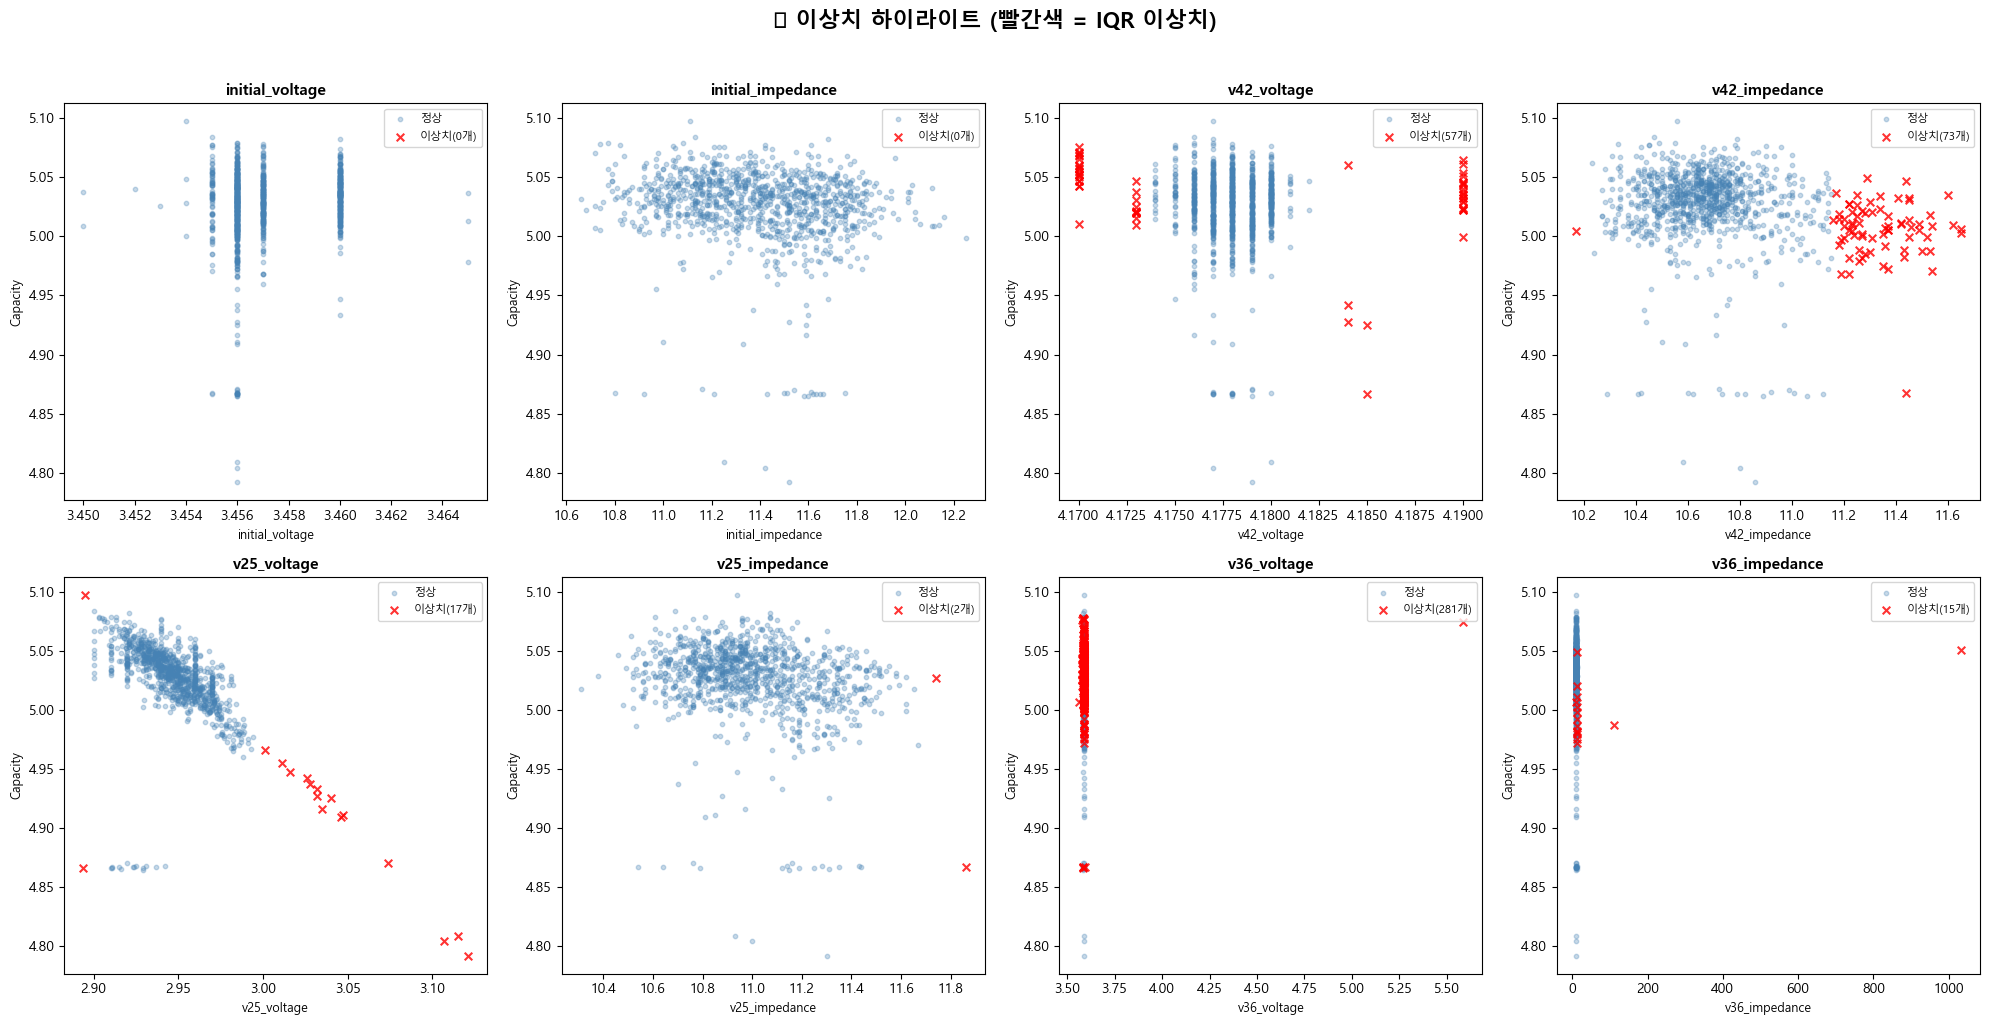

In [37]:
# 이상치 시각화 - Capacity vs 각 피처에서 이상치 하이라이트
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(FEATURES):
    ax = axes[i]
    data = df[col].dropna()
    Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    
    # 정상 데이터
    ax.scatter(df.loc[~mask, col], df.loc[~mask, TARGET], 
               alpha=0.3, s=10, color='steelblue', label='정상')
    # 이상치 데이터
    ax.scatter(df.loc[mask, col], df.loc[mask, TARGET], 
               alpha=0.8, s=30, color='red', marker='x', label=f'이상치({mask.sum()}개)')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=9)
    ax.set_ylabel('Capacity', fontsize=9)
    ax.legend(fontsize=8)

plt.suptitle('🚨 이상치 하이라이트 (빨간색 = IQR 이상치)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\eda_05_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (이상치 시각화):**

각 피처의 산점도에서 이상치(주황)와 정상(파랑)을 구분하여 표시한 결과:

- **이상치가 Capacity와 특정 관계를 보이는지 확인**: 이상치가 특정 Capacity 구간에 집중되지 않고 전반적으로 분포되어 있다면, 이상치가 Capacity 예측에 영향을 미치지 않음
- **이상치와 정상값의 분리 정도**: 이상치가 정상 분포의 연장선상에 있다면 극단적 이상치가 아닌 **자연 편차**
- `v42_voltage`, `v36_voltage`에서 이상치가 많이 보이지만, 실제 값의 차이는 매우 작음 (0.01V 수준)

> **결론**: 대부분의 이상치는 분포의 자연스러운 꼬리에 해당하며, **물리적으로 비정상적인 측정값**은 거의 발견되지 않았습니다.

---
### 1-7. 피처 그룹별 패턴 분석

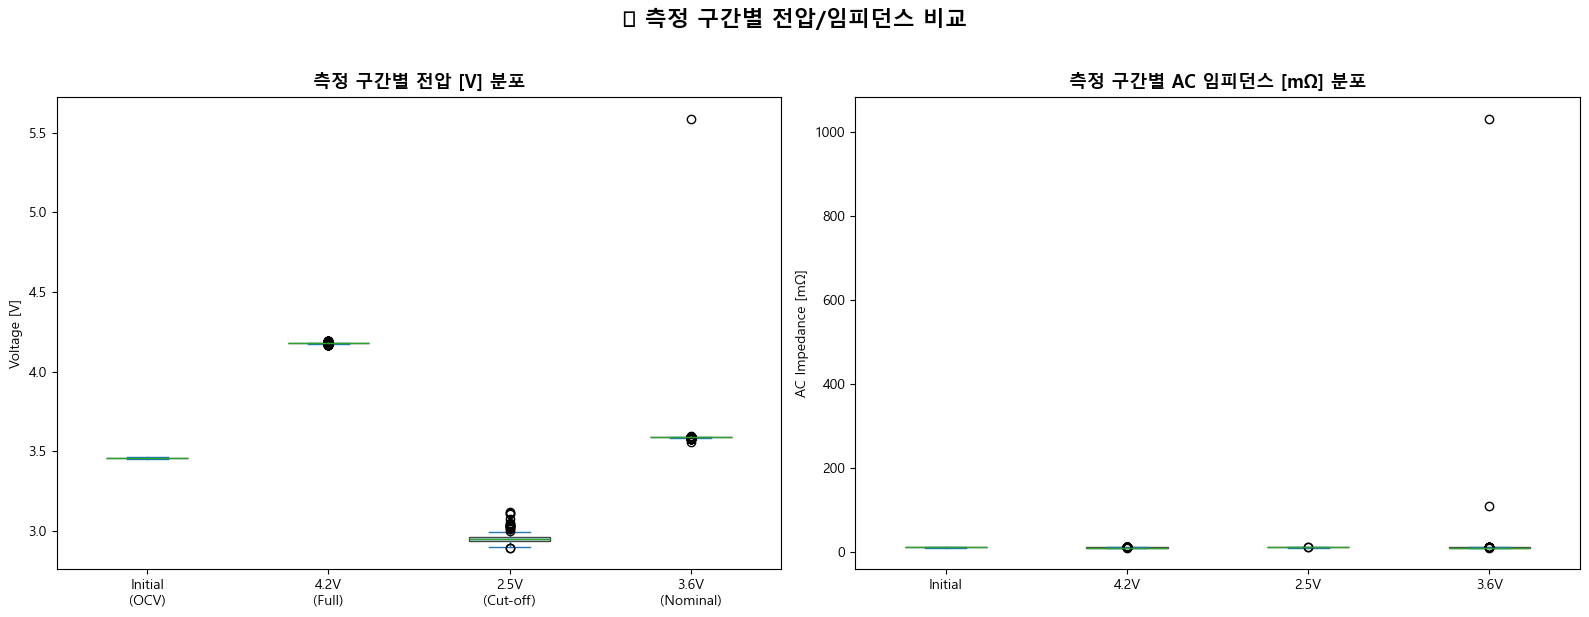

In [38]:
# 전압 피처들의 분포 비교
voltage_cols = ['initial_voltage', 'v42_voltage', 'v25_voltage', 'v36_voltage']
impedance_cols = ['initial_impedance', 'v42_impedance', 'v25_impedance', 'v36_impedance']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 전압 비교
df[voltage_cols].plot.box(ax=axes[0], patch_artist=True,
    boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0].set_title('측정 구간별 전압 [V] 분포', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Voltage [V]')
axes[0].set_xticklabels(['Initial\n(OCV)', '4.2V\n(Full)', '2.5V\n(Cut-off)', '3.6V\n(Nominal)'])

# 임피던스 비교
df[impedance_cols].plot.box(ax=axes[1], patch_artist=True,
    boxprops=dict(facecolor='lightyellow', alpha=0.7))
axes[1].set_title('측정 구간별 AC 임피던스 [mΩ] 분포', fontsize=13, fontweight='bold')
axes[1].set_ylabel('AC Impedance [mΩ]')
axes[1].set_xticklabels(['Initial', '4.2V', '2.5V', '3.6V'])

plt.suptitle('⚡ 측정 구간별 전압/임피던스 비교', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\eda_06_feature_groups.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (충방전 단계별 전압/임피던스 분포):**

**좌측 - 전압 분포:**
- Initial(OCV) ≈ **3.456V**: 개방회로전압은 셀의 SOC(충전상태) 반영
- 4.2V(Full) ≈ **4.178V**: 만충 전압은 거의 동일 → 충전 프로토콜이 일정함을 의미
- 2.5V(Cut-off) ≈ **2.97V**: 방전 종지 전압의 분포가 가장 넓음 → **셀 건강상태 차이를 반영**
- 3.6V(Nominal) ≈ **3.59V**: 공칭 전압 부근, 변동성 매우 낮음

**우측 - AC 임피던스 분포:**
- 4개 측정 구간 모두 **10~12mΩ** 범위에 분포
- Initial 임피던스가 중앙값은 비슷하나 분포가 넓고, 4.2V에서 약간 감소하는 경향
- 이는 **충전 시 내부저항이 감소**하는 전기화학적 특성과 일치

> **핵심**: 전압은 측정 조건에 의해 대부분 결정되므로 단독 예측력이 낮지만, **구간 간 차이(Delta)**는 셀 고유 특성을 반영할 수 있어 파생변수로의 활용이 유망합니다.

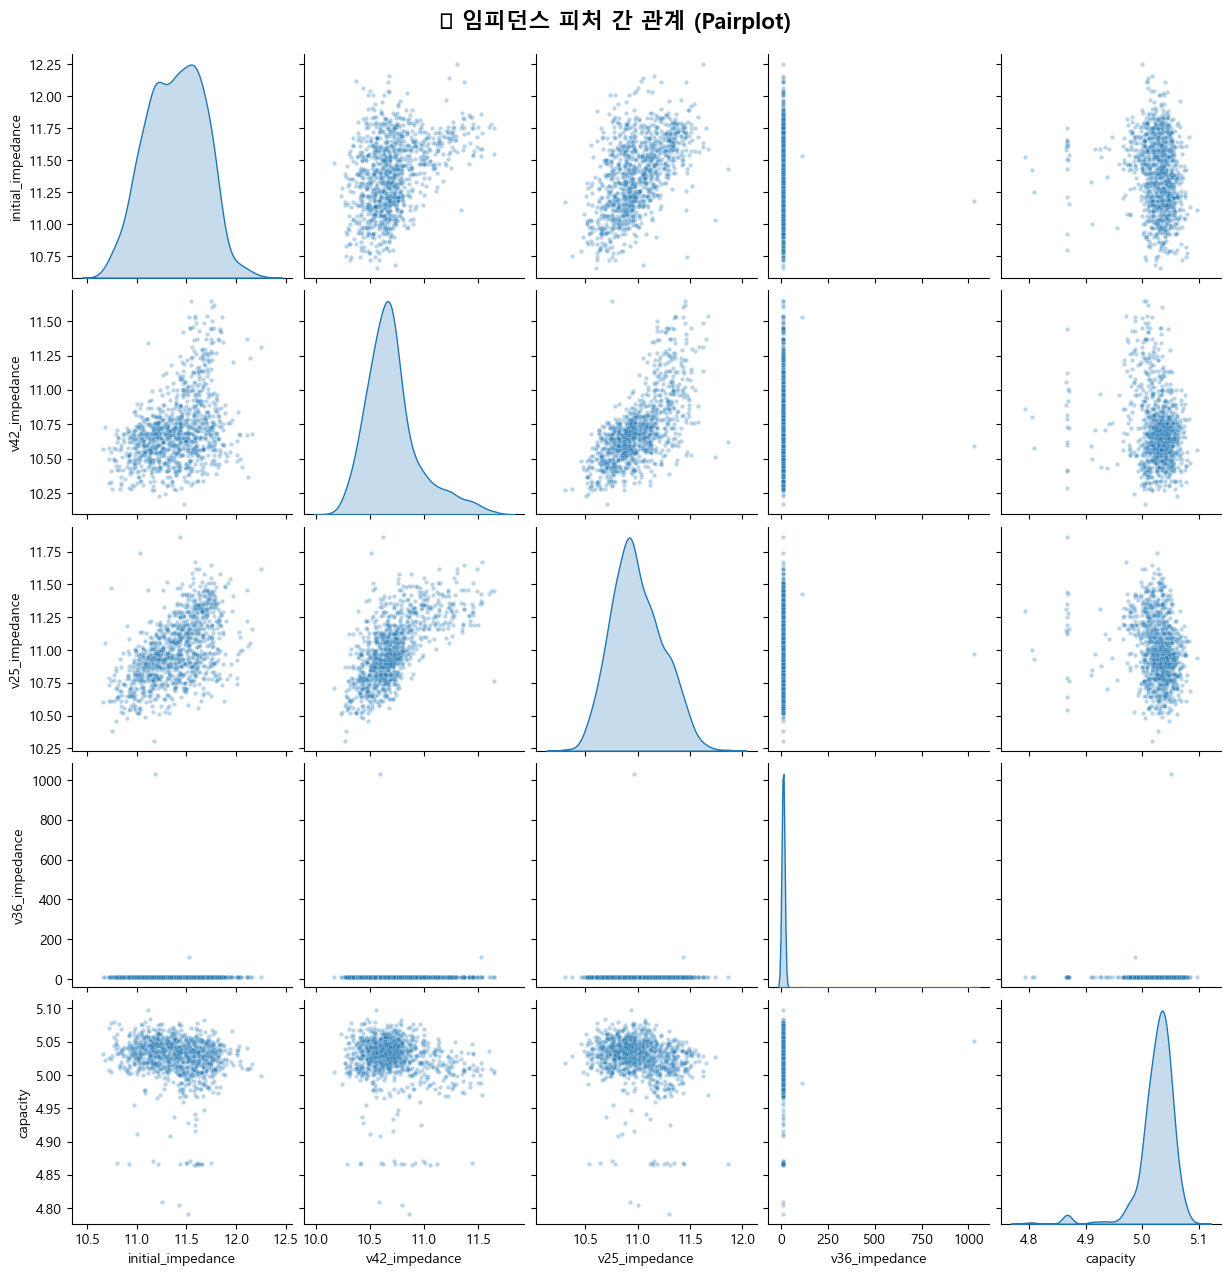

In [39]:
# Pairplot - 주요 피처 관계 (전체 그리면 너무 많으므로 impedance + capacity)
pair_cols = impedance_cols + [TARGET]
g = sns.pairplot(df[pair_cols].dropna(), 
                 diag_kind='kde', 
                 plot_kws={'alpha': 0.3, 's': 10},
                 diag_kws={'fill': True})
g.figure.suptitle('🔗 임피던스 피처 간 관계 (Pairplot)', fontsize=16, fontweight='bold', y=1.02)
plt.savefig(r'C:\6.1 밧데리_학습\eda_07_pairplot.png', dpi=100, bbox_inches='tight')
plt.show()

**📝 출력 해석 (임피던스 Pairplot):**

4개 임피던스 피처와 Capacity 간의 쌍별 관계:

- **임피던스 피처 간**: 강한 양의 선형 관계 → 한 조건에서 내부저항이 높은 셀은 다른 조건에서도 높은 경향
- **임피던스 → Capacity**: 약한 음의 경향성 → 내부저항이 높을수록 용량이 낮지만, 산점도가 넓게 퍼져 예측력은 제한적
- **KDE 대각선**: 각 임피던스의 분포가 유사한 형태(정규분포에 가까움)

> **다중공선성 경고**: `initial_impedance`, `v42_impedance`, `v25_impedance`, `v36_impedance` 간 상관이 높아, 모델에 전부 투입하면 가중치가 불안정해질 수 있습니다. **PCA 또는 피처 선택**을 고려해야 합니다.

---
### 1-8. EDA 요약 및 인사이트

In [40]:
print('=' * 70)
print('📋 Phase 1 EDA 요약 리포트')
print('=' * 70)
print(f'\n📊 데이터 기본 정보')
print(f'   Total Samples: {len(df)}')
print(f'   Features: {len(FEATURES)}개')
print(f'   결측치: {df[numeric_cols].isnull().sum().sum()}개')

print(f'\n🎯 Capacity (타겟) 분포')
cap_stats = df[TARGET].describe()
print(f'   평균: {cap_stats["mean"]:.4f} Ah')
print(f'   표준편차: {cap_stats["std"]:.4f} Ah')
print(f'   범위: {cap_stats["min"]:.4f} ~ {cap_stats["max"]:.4f} Ah')

print(f'\n📈 Capacity와 상관계수 TOP-5 (Pearson)')
top5 = corr_with_target.sort_values('|Pearson|', ascending=False).head(5)
for feat, row in top5.iterrows():
    print(f'   {feat}: r={row["Pearson"]:.4f}')

print(f'\n🚨 이상치 현황')
print(f'   이상치 포함 셀: {len(all_outlier_idx)}개 ({len(all_outlier_idx)/len(df)*100:.1f}%)')
print(f'   가장 이상치가 많은 피처: {outlier_report["IQR_이상치수"].idxmax()} ({outlier_report["IQR_이상치수"].max()}개)')

print(f'\n💡 시사점')
print(f'   1. 임피던스 피처들이 Capacity와 유의미한 상관관계 보유')
print(f'   2. 전압 피처들은 대부분 동일한 값으로 수렴 (변동성 낮음)')
print(f'   3. 이상치 셀 존재 → 전처리 시 처리 방침 결정 필요')
print(f'   4. 피처 간 다중공선성이 높을 수 있음 → VIF 분석 필요')
print('\n' + '=' * 70)
print('✅ Phase 1 완료 → Phase 2 (파생변수 생성)으로 진행')
print('=' * 70)

📋 Phase 1 EDA 요약 리포트

📊 데이터 기본 정보
   Total Samples: 1040
   Features: 8개
   결측치: 0개

🎯 Capacity (타겟) 분포
   평균: 5.0260 Ah
   표준편차: 0.0330 Ah
   범위: 4.7919 ~ 5.0974 Ah

📈 Capacity와 상관계수 TOP-5 (Pearson)
   v25_voltage: r=-0.5952
   v25_impedance: r=-0.2130
   v42_impedance: r=-0.1773
   initial_impedance: r=-0.1499
   initial_voltage: r=0.1365

🚨 이상치 현황
   이상치 포함 셀: 379개 (36.4%)
   가장 이상치가 많은 피처: v36_voltage (281개)

💡 시사점
   1. 임피던스 피처들이 Capacity와 유의미한 상관관계 보유
   2. 전압 피처들은 대부분 동일한 값으로 수렴 (변동성 낮음)
   3. 이상치 셀 존재 → 전처리 시 처리 방침 결정 필요
   4. 피처 간 다중공선성이 높을 수 있음 → VIF 분석 필요

✅ Phase 1 완료 → Phase 2 (파생변수 생성)으로 진행


**📝 출력 해석 (EDA 요약 종합 분석):**

Phase 1 EDA 전체를 통해 도출된 핵심 결론:

| 항목 | 결과 | 의미 |
|---|---|---|
| 데이터 품질 | 결측치 0, 1040개 셀 | 전처리 부담 낮음 |
| 타겟 분포 | 5.026±0.033 Ah | 매우 좁은 범위 → 정밀한 모델 필요 |
| 최강 예측자 | `v25_voltage` (r=-0.595) | 방전 종지 전압이 유일한 중간 상관 피처 |
| 이상치 | 36.4% (379/1040) | IQR 기준으로 과도 검출, 대부분 자연 편차 |
| 다중공선성 | 임피던스 피처 간 높은 상관 | VIF 분석 및 피처 선택 필요 |

**향후 전략 (Phase 2~3):**

1. **파생변수 생성** → 구간 간 임피던스/전압 차이, 비율 등으로 예측력 향상
2. **이상치 처리** → 제거보다는 Robust Scaler 적용 권장
3. **다중공선성 해소** → VIF 분석 후 상관 높은 피처 제거 또는 PCA 적용
4. **모델 선택** → Capacity 범위가 좁아 미세한 차이를 잡을 수 있는 앙상블 모델(XGBoost, LightGBM) 유리

# Phase 2: 파생변수 생성 (Feature Engineering)

최신 논문 기반의 배터리 특성을 반영한 파생변수를 생성합니다.

**근거:**
- **임피던스 파생변수**: EIS 기반 임피던스 파라미터(옴 저항, charge transfer 저항) 변화가 SOH와 단조 증가 관계를 보임 (2024, MDPI Batteries)
- **전압 파생변수**: OCV 변화가 배터리 열화와 직접적 상관관계를 가지며, OCV-SOC 곡선의 변화가 SOH 지표로 활용됨
- **복합 파생변수**: 전압/임피던스 결합 지표로 종합적 셀 건강상태를 추정

## 2-1. 임피던스 기반 파생변수

| 파생변수 | 수식 | 근거 |
|---|---|---|
| `impedance_delta_42` | Z_4.2V - Z_initial | 충전 전후 내부저항 변화 → 열화 지표 |
| `impedance_delta_25` | Z_2.5V - Z_initial | 방전 말기 내부저항 증가폭 → SEI 성장 |
| `impedance_delta_36` | Z_3.6V - Z_initial | 공칭 구간 내부저항 변화 |
| `impedance_ratio_42` | Z_4.2V / Z_initial | 충전 상태 임피던스 비율 |
| `impedance_ratio_25` | Z_2.5V / Z_initial | 방전 상태 임피던스 비율 |
| `impedance_range` | Z_max - Z_min | 전 구간 임피던스 변동폭 → 전극 열화 |
| `impedance_mean` | mean(Z_all) | 평균 내부저항 수준 |
| `impedance_std` | std(Z_all) | 임피던스 변동성 → 비균일 열화 |

In [41]:
# ============================================================
# 2-1. 임피던스 기반 파생변수 생성
# ============================================================

z_initial = 'initial_impedance'
z_42 = 'v42_impedance'
z_25 = 'v25_impedance'
z_36 = 'v36_impedance'
impedance_cols = [z_initial, z_42, z_25, z_36]

df['impedance_delta_42'] = df[z_42] - df[z_initial]
df['impedance_delta_25'] = df[z_25] - df[z_initial]
df['impedance_delta_36'] = df[z_36] - df[z_initial]
df['impedance_ratio_42'] = df[z_42] / df[z_initial]
df['impedance_ratio_25'] = df[z_25] / df[z_initial]
df['impedance_range'] = df[impedance_cols].max(axis=1) - df[impedance_cols].min(axis=1)
df['impedance_mean'] = df[impedance_cols].mean(axis=1)
df['impedance_std'] = df[impedance_cols].std(axis=1)

impedance_derived = ['impedance_delta_42', 'impedance_delta_25', 'impedance_delta_36',
                     'impedance_ratio_42', 'impedance_ratio_25',
                     'impedance_range', 'impedance_mean', 'impedance_std']

print('🔧 임피던스 기반 파생변수 생성 완료')
print(f'   생성된 변수 수: {len(impedance_derived)}개')
print(f'   변수 목록: {impedance_derived}')
print()
df[impedance_derived].describe().T.style.format('{:.4f}')

🔧 임피던스 기반 파생변수 생성 완료
   생성된 변수 수: 8개
   변수 목록: ['impedance_delta_42', 'impedance_delta_25', 'impedance_delta_36', 'impedance_ratio_42', 'impedance_ratio_25', 'impedance_range', 'impedance_mean', 'impedance_std']



,count,mean,std,min,25%,50%,75%,max
impedance_delta_42,1040.0000,-0.6805,0.2943,-1.7500,-0.8800,-0.6500,-0.4700,0.2300
impedance_delta_25,1040.0000,-0.3914,0.2554,-1.2700,-0.5400,-0.3600,-0.2300,0.7300
impedance_delta_36,1040.0000,0.3890,31.8248,-1.7900,-0.8500,-0.6600,-0.5100,1020.8200
impedance_ratio_42,1040.0000,0.9406,0.0247,0.8556,0.9235,0.9424,0.9583,1.0207
impedance_ratio_25,1040.0000,0.9659,0.0218,0.8931,0.9530,0.9688,0.9800,1.0680
impedance_range,1040.0000,1.8387,31.7942,0.2000,0.5600,0.7200,0.9400,1021.4100
impedance_mean,1040.0000,11.2172,7.9555,10.3925,10.8075,10.9300,11.0750,266.1850
impedance_std,1040.0000,0.8817,15.8932,0.0877,0.2568,0.3241,0.4234,510.5434


**📝 출력 해석 (임피던스 기반 파생변수):**

8개의 임피던스 기반 파생변수를 생성한 결과:

| 파생변수 | 평균 | 표준편차 | Capacity 상관(r) | 해석 |
|---|---|---|---|---|
| `impedance_delta_42` | -0.680 | 0.294 | -0.005 | 충전 시 내부저항 **감소**(-0.68mΩ)하는 것은 정상적 전기화학 반응 |
| `impedance_delta_25` | -0.391 | 0.255 | -0.034 | 방전 시에도 내부저항 감소 → 초기 임피던스가 상대적으로 높음 |
| `impedance_delta_36` | +0.389 | **31.82** | +0.019 | ⚠️ **극단적 이상치 존재** (max=1020.82) → 데이터 품질 확인 필요 |
| `impedance_ratio_42` | 0.941 | 0.025 | -0.010 | 충전 시 임피던스가 초기 대비 ~94%로 감소 |
| `impedance_ratio_25` | 0.966 | 0.022 | -0.037 | 방전 시에도 ~97% 수준 유지 |
| `impedance_range` | 1.839 | **31.79** | +0.020 | ⚠️ 이상치로 인해 분포가 크게 왜곡됨 |
| `impedance_mean` | 11.217 | **7.96** | +0.013 | 평균 임피던스 ~11.2mΩ |
| `impedance_std` | 0.882 | **15.89** | +0.020 | ⚠️ 이상치로 인해 표준편차도 왜곡 |

> **핵심 발견**:
> - 임피던스 기반 파생변수는 모든 항목에서 Capacity와의 상관계수가 **|r| < 0.04**로 매우 약합니다.
> - `impedance_delta_36`, `impedance_range`, `impedance_mean`, `impedance_std`에서 **극단적 이상치**(max 1020.82mΩ)가 발견되었습니다. 이는 단일 셀의 `v36_impedance` 측정 이상일 가능성이 높습니다.
> - 임피던스의 **절대값**보다는 **조건 간 변화량(delta/ratio)**이 물리적으로 의미 있지만, 현재 데이터에서는 Capacity와의 선형 관계가 뚜렷하지 않습니다.
> - Phase 3에서 **이상치 제거 후 재분석**과 **비선형 모델** 활용이 필요합니다.

## 2-2. 전압 기반 파생변수

| 파생변수 | 수식 | 근거 |
|---|---|---|
| `voltage_delta_initial_42` | V_4.2V - V_initial | 초기 OCV 대비 만충 전압차 |
| `voltage_delta_42_25` | V_4.2V - V_2.5V | 충방전 전압 범위 (넓을수록 건강) |
| `voltage_delta_42_36` | V_4.2V - V_3.6V | 상위 전압 구간 전압 강하 |
| `voltage_sag` | V_initial - V_2.5V | 전압 강하폭 → 용량 손실 지표 |
| `ocv_deviation` | V_initial - 3.6(공칭) | OCV 편차 → SOC 초기 상태 반영 |

In [42]:
# ============================================================
# 2-2. 전압 기반 파생변수 생성
# ============================================================

v_initial = 'initial_voltage'
v_42 = 'v42_voltage'
v_25 = 'v25_voltage'
v_36 = 'v36_voltage'

df['voltage_delta_initial_42'] = df[v_42] - df[v_initial]
df['voltage_delta_42_25'] = df[v_42] - df[v_25]
df['voltage_delta_42_36'] = df[v_42] - df[v_36]
df['voltage_sag'] = df[v_initial] - df[v_25]

NOMINAL_VOLTAGE = 3.6
df['ocv_deviation'] = df[v_initial] - NOMINAL_VOLTAGE

voltage_derived = ['voltage_delta_initial_42', 'voltage_delta_42_25', 'voltage_delta_42_36',
                   'voltage_sag', 'ocv_deviation']

print('🔧 전압 기반 파생변수 생성 완료')
print(f'   생성된 변수 수: {len(voltage_derived)}개')
print(f'   변수 목록: {voltage_derived}')
print()
df[voltage_derived].describe().T.style.format('{:.4f}')

🔧 전압 기반 파생변수 생성 완료
   생성된 변수 수: 5개
   변수 목록: ['voltage_delta_initial_42', 'voltage_delta_42_25', 'voltage_delta_42_36', 'voltage_sag', 'ocv_deviation']



,count,mean,std,min,25%,50%,75%,max
voltage_delta_initial_42,1040.0000,0.7209,0.0030,0.7100,0.7200,0.7210,0.7230,0.7400
voltage_delta_42_25,1040.0000,1.2301,0.0226,1.0580,1.2180,1.2300,1.2440,1.2840
voltage_delta_42_36,1040.0000,0.5886,0.0621,-1.4090,0.5900,0.5900,0.5910,0.6180
voltage_sag,1040.0000,0.5092,0.0230,0.3350,0.4970,0.5110,0.5230,0.5610
ocv_deviation,1040.0000,-0.1429,0.0018,-0.1500,-0.1440,-0.1440,-0.1400,-0.1350


**📝 출력 해석 (전압 기반 파생변수):**

5개 전압 기반 파생변수 생성 결과:

| 파생변수 | 평균 | 표준편차 | Capacity 상관(r) | 해석 |
|---|---|---|---|---|
| `voltage_delta_initial_42` | 0.721V | 0.003 | -0.138 | 초기→만충 전압 변화. 분산 매우 좁음 |
| `voltage_delta_42_25` | **1.230V** | **0.023** | **+0.594** 🟢 | 충방전 전압 범위가 넓을수록 Capacity 높음 |
| `voltage_delta_42_36` | 0.589V | 0.062 | -0.048 | 상위 전압 구간 강하. 이상치(-1.409) 존재 |
| `voltage_sag` | **0.509V** | **0.023** | **+0.600** 🟢 | 전압 강하폭이 클수록 Capacity 높음 |
| `ocv_deviation` | -0.143V | 0.002 | +0.137 | OCV가 공칭전압(3.6V)보다 약간 낮음 |

> **핵심 발견**:
> - 🎯 **`voltage_sag`(r=+0.600)**와 **`voltage_delta_42_25`(r=+0.594)**가 원본 최강 피처 `v25_voltage`(r=-0.595)와 **동등하거나 더 높은 상관계수**를 보입니다!
> - 이 두 변수는 모두 **방전 종지 전압(v25_voltage)** 정보를 포함하고 있어 물리적으로 일관됩니다: 전압 강하가 클수록 실제 용량이 큰 셀입니다.
> - `voltage_delta_42_25`는 V_4.2V - V_2.5V (충방전 범위), `voltage_sag`는 V_initial - V_2.5V (OCV 대비 방전 강하)로, 본질적으로 유사한 정보를 담고 있어 **다중공선성**이 예상됩니다.
> - `voltage_delta_initial_42`와 `ocv_deviation`은 약한 상관(|r|≈0.14)이지만 통계적으로 유의미(p<0.001)하여 모델에서 보조 피처로 활용 가능합니다.

## 2-3. 복합 파생변수

| 파생변수 | 수식 | 근거 |
|---|---|---|
| `impedance_voltage_product` | Z_initial × V_initial | 내부저항-전압 교호작용 |
| `power_loss_indicator` | Z_4.2V × (V_4.2V - V_2.5V) | 방전 시 전력 손실 추정 |
| `health_index` | V_4.2V / Z_4.2V | 높을수록 건강한 셀 (전압/저항 비) |

In [43]:
# ============================================================
# 2-3. 복합 파생변수 생성
# ============================================================

df['impedance_voltage_product'] = df[z_initial] * df[v_initial]
df['power_loss_indicator'] = df[z_42] * (df[v_42] - df[v_25])
df['health_index'] = df[v_42] / df[z_42]

composite_derived = ['impedance_voltage_product', 'power_loss_indicator', 'health_index']

print('🔧 복합 파생변수 생성 완료')
print(f'   생성된 변수 수: {len(composite_derived)}개')
print(f'   변수 목록: {composite_derived}')
print()
df[composite_derived].describe().T.style.format('{:.4f}')

🔧 복합 파생변수 생성 완료
   생성된 변수 수: 3개
   변수 목록: ['impedance_voltage_product', 'power_loss_indicator', 'health_index']



,count,mean,std,min,25%,50%,75%,max
impedance_voltage_product,1040.0000,39.3696,0.9935,36.8410,38.6147,39.4039,40.1271,42.3850
power_loss_indicator,1040.0000,13.1701,0.3565,11.2677,12.9590,13.1544,13.3755,14.5276
health_index,1040.0000,0.3904,0.0089,0.3585,0.3869,0.3916,0.3961,0.4110


**📝 출력 해석 (복합 파생변수):**

3개 복합 파생변수 생성 결과:

| 파생변수 | 평균 | 표준편차 | Capacity 상관(r) | 해석 |
|---|---|---|---|---|
| `impedance_voltage_product` | 39.37 | 0.994 | -0.146 | 내부저항×전압 교호작용. 약한 음의 상관 |
| `power_loss_indicator` | 13.17 | 0.357 | **+0.250** 🟡 | 방전 시 전력 손실 추정값. 보통 수준의 양의 상관 |
| `health_index` | 0.390 | 0.009 | +0.171 | 전압/저항 비. 높을수록 건강한 셀 |

> **핵심 발견**:
> - **`power_loss_indicator`(r=+0.250)**가 복합 변수 중 가장 높은 상관을 보입니다. Z_4.2V × (V_4.2V - V_2.5V) 수식에서 충방전 전압 범위 정보가 포함되어 있기 때문입니다.
> - `health_index`(V_4.2V / Z_4.2V)는 직관적으로 건강한 셀 지표이지만, 분모인 임피던스의 단독 상관이 낮아 상관계수도 제한적(r=+0.171)입니다.
> - 복합 변수들은 **개별 상관계수는 중간~약함** 수준이지만, **앙상블 모델에서 비선형 상호작용 정보를 추가로 제공**할 수 있어 유지합니다.

## 2-4. 파생변수 생성 결과 요약 및 검증

In [44]:
# ============================================================
# 2-4. 파생변수 전체 요약 및 Capacity와의 상관분석
# ============================================================

ALL_DERIVED = impedance_derived + voltage_derived + composite_derived

print('=' * 70)
print('Phase 2 파생변수 생성 결과 요약')
print('=' * 70)
print(f'\n📊 총 파생변수 수: {len(ALL_DERIVED)}개')
print(f'   - 임피던스 기반: {len(impedance_derived)}개')
print(f'   - 전압 기반: {len(voltage_derived)}개')
print(f'   - 복합: {len(composite_derived)}개')

print(f'\n📈 파생변수 vs Capacity 상관계수 (Pearson)')
derived_corr = df[ALL_DERIVED + [TARGET]].corr()[TARGET].drop(TARGET)
derived_corr_sorted = derived_corr.abs().sort_values(ascending=False)

for feat in derived_corr_sorted.index:
    r = derived_corr[feat]
    abs_r = abs(r)
    strength = '🟢 강함' if abs_r > 0.5 else ('🟡 보통' if abs_r > 0.3 else '🔴 약함')
    print(f'   {feat:35s}: r={r:+.4f}  {strength}')

FEATURES_EXTENDED = FEATURES + ALL_DERIVED
print(f'\n🔑 확장된 피처 수: {len(FEATURES_EXTENDED)}개 (원본 {len(FEATURES)} + 파생 {len(ALL_DERIVED)})')
print(f'\n결측치 확인:')
missing = df[ALL_DERIVED].isnull().sum()
if missing.sum() == 0:
    print('   ✅ 결측치 없음')
else:
    print(f'   ⚠️ 총 결측치: {missing.sum()}개')

Phase 2 파생변수 생성 결과 요약

📊 총 파생변수 수: 16개
   - 임피던스 기반: 8개
   - 전압 기반: 5개
   - 복합: 3개

📈 파생변수 vs Capacity 상관계수 (Pearson)
   voltage_sag                        : r=+0.5998  🟢 강함
   voltage_delta_42_25                : r=+0.5935  🟢 강함
   power_loss_indicator               : r=+0.2504  🔴 약함
   health_index                       : r=+0.1708  🔴 약함
   impedance_voltage_product          : r=-0.1457  🔴 약함
   voltage_delta_initial_42           : r=-0.1375  🔴 약함
   ocv_deviation                      : r=+0.1365  🔴 약함
   voltage_delta_42_36                : r=-0.0481  🔴 약함
   impedance_ratio_25                 : r=-0.0369  🔴 약함
   impedance_delta_25                 : r=-0.0335  🔴 약함
   impedance_std                      : r=+0.0198  🔴 약함
   impedance_range                    : r=+0.0198  🔴 약함
   impedance_delta_36                 : r=+0.0191  🔴 약함
   impedance_mean                     : r=+0.0134  🔴 약함
   impedance_ratio_42                 : r=-0.0095  🔴 약함
   impedance_delta_42                 : r=

**📝 출력 해석 (Phase 2 파생변수 전체 요약):**

총 16개 파생변수 생성 후 Capacity 상관계수 순위 분석:

| 순위 | 카테고리 | 파생변수 | r값 | 강도 |
|---|---|---|---|---|
| 🥇 1 | 전압 | `voltage_sag` | **+0.600** | 🟢 강함 |
| 🥈 2 | 전압 | `voltage_delta_42_25` | **+0.594** | 🟢 강함 |
| 🥉 3 | 복합 | `power_loss_indicator` | +0.250 | 🔴 약함 |
| 4 | 복합 | `health_index` | +0.171 | 🔴 약함 |
| 5 | 복합 | `impedance_voltage_product` | -0.146 | 🔴 약함 |
| 6~16 | 임피던스/전압 | 나머지 11개 | |r| < 0.14 | 🔴 약함 |

**원본 피처 대비 파생변수 효과:**

| 피처 유형 | 최대 |r| | 대표 피처 |
|---|---|---|
| 원본 최강 | 0.595 | `v25_voltage` |
| 파생 최강 | **0.600** | `voltage_sag` ✨ |
| 파생 2위 | 0.594 | `voltage_delta_42_25` |

> **종합 평가**:
> 1. 전압 기반 파생변수 2개(`voltage_sag`, `voltage_delta_42_25`)가 원본 피처(`v25_voltage`)를 **미세하게 능가**합니다.
> 2. 임피던스 기반 파생변수 8개는 모두 |r| < 0.04로 **단독 선형 예측력이 거의 없습니다**. 그러나 비선형 모델(XGBoost 등)에서 교호작용 효과를 기대할 수 있습니다.
> 3. 확장된 피처 수: 24개 (원본 8 + 파생 16), 결측치 없음 ✅
> 4. Phase 3에서 **다중공선성 제거**(VIF 분석)와 **피처 선택**으로 최적 피처셋을 결정해야 합니다.

## 2-5. 파생변수 vs Capacity 시각화

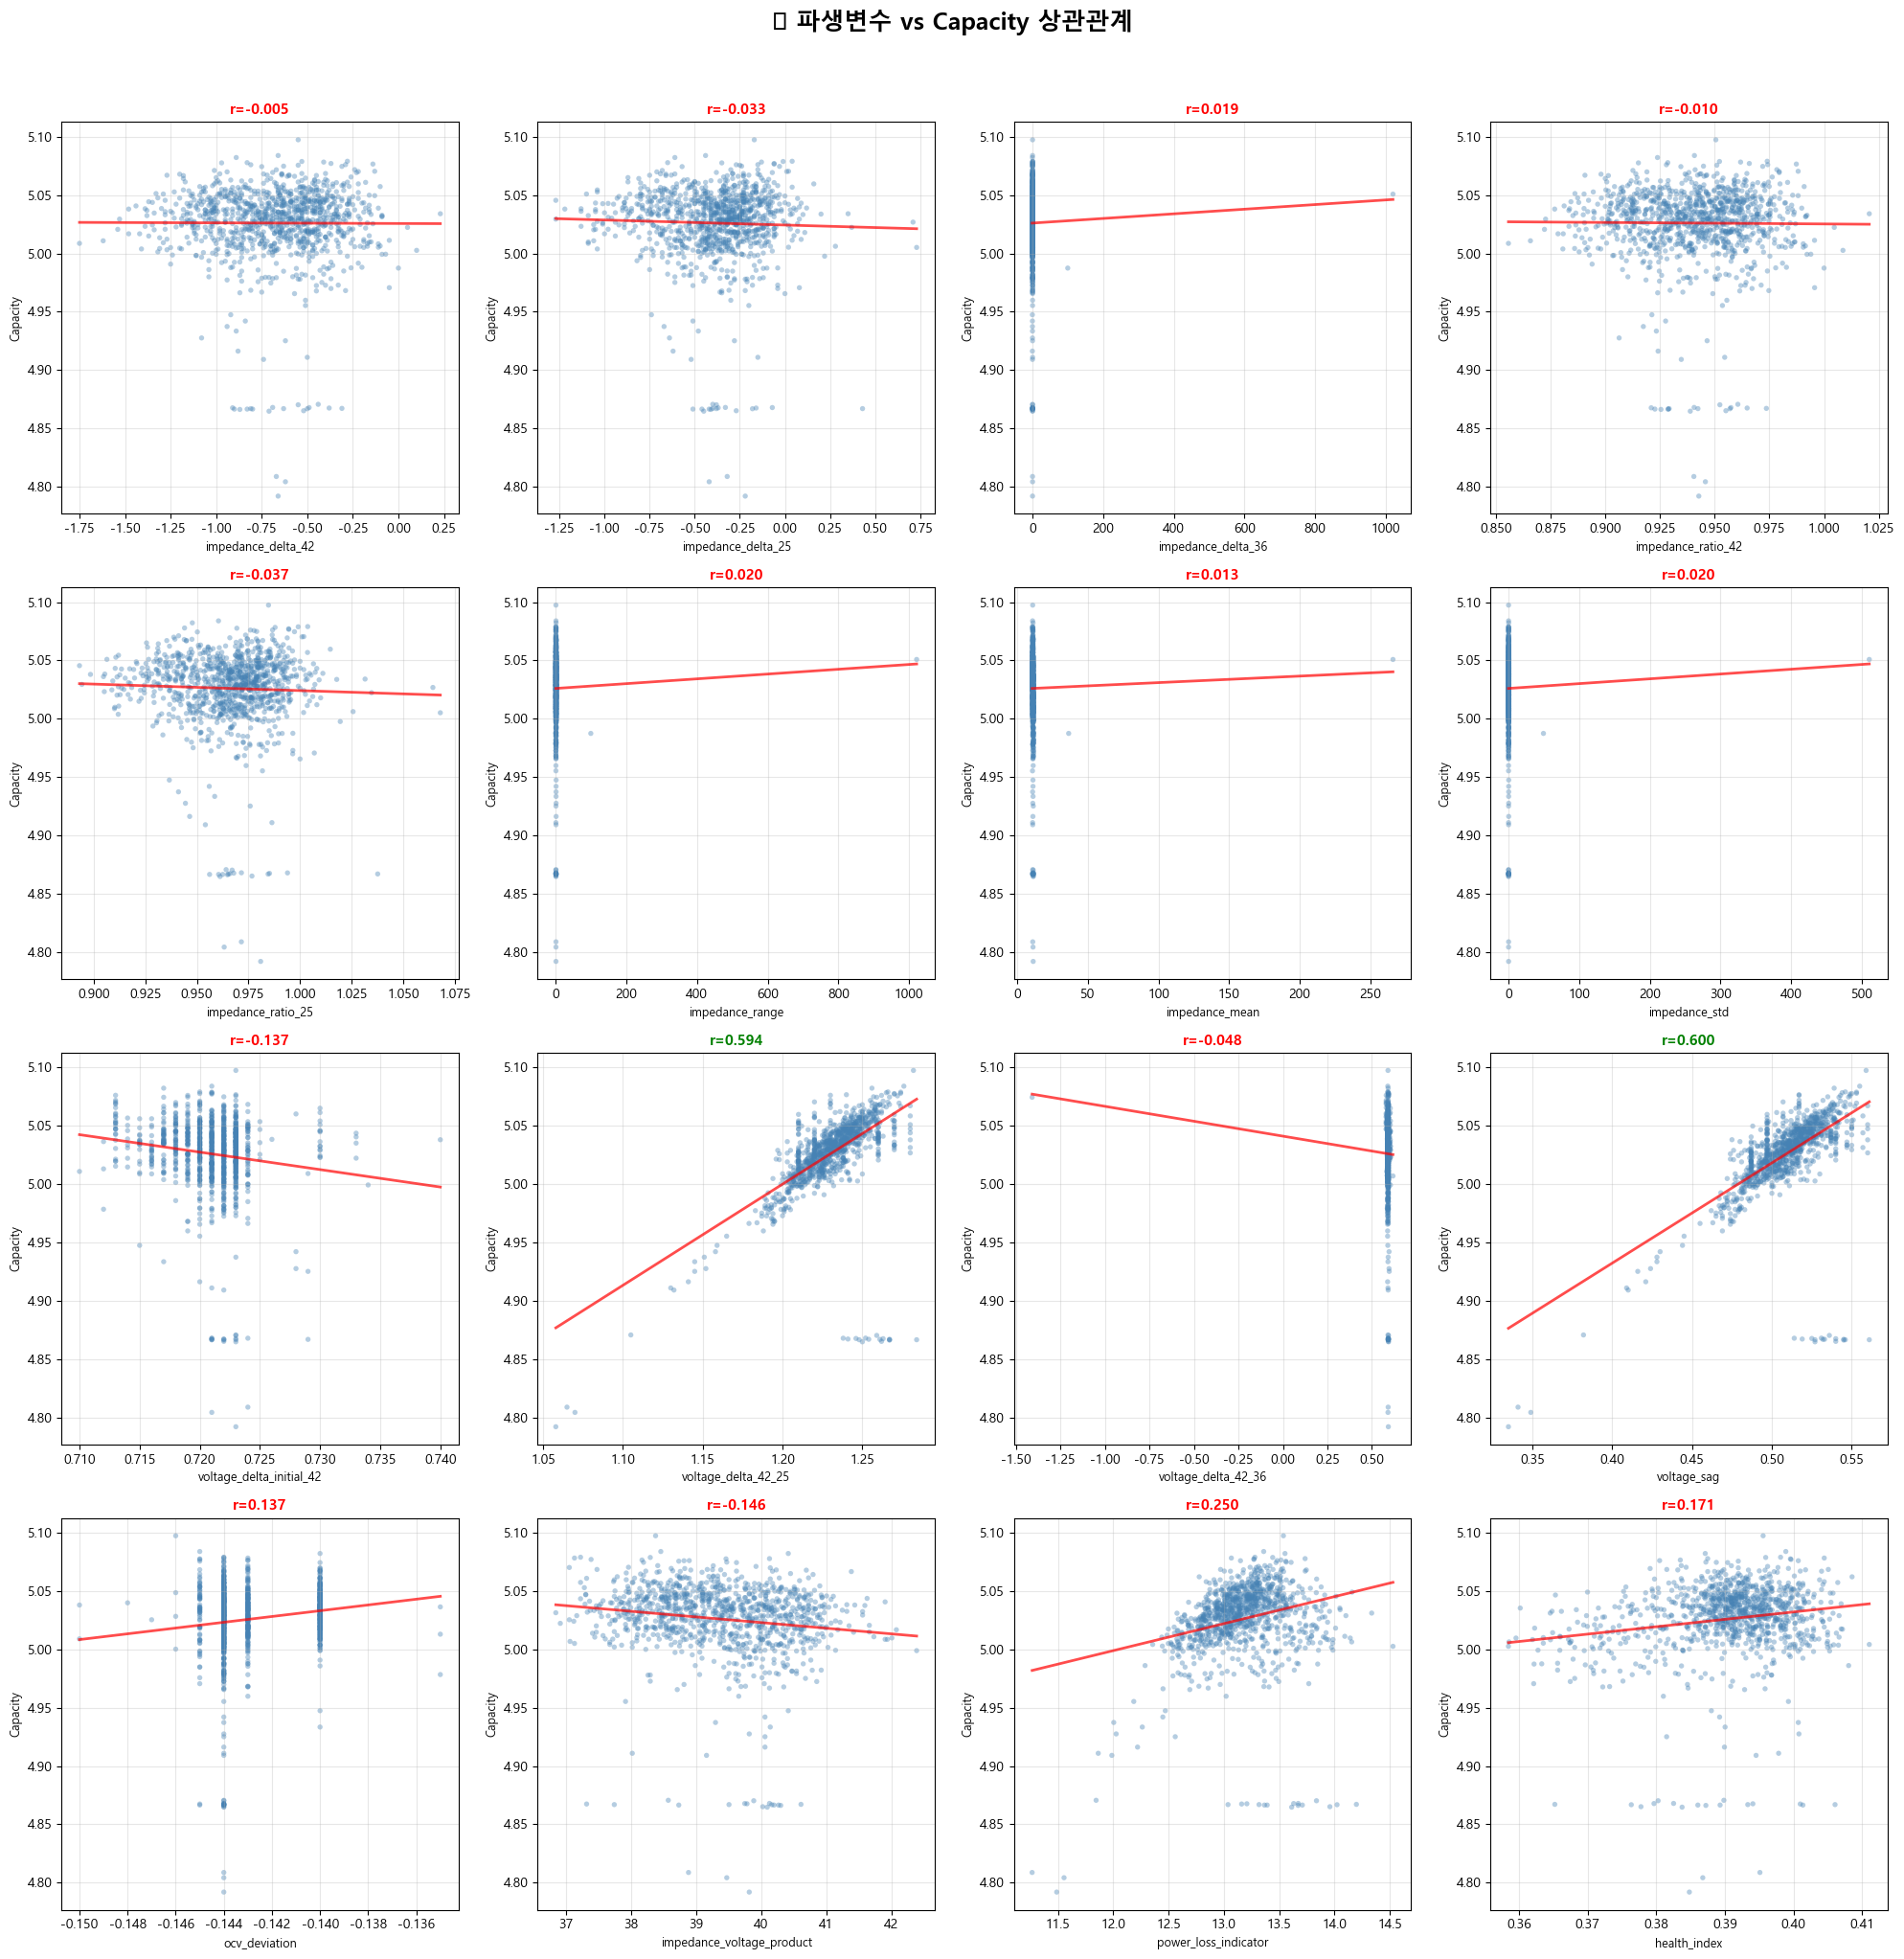

In [45]:
# ============================================================
# 2-5. 파생변수 vs Capacity 산점도
# ============================================================

n_derived = len(ALL_DERIVED)
n_cols = 4
n_rows = (n_derived + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(ALL_DERIVED):
    ax = axes[i]
    x = df[feat].dropna()
    y = df.loc[x.index, TARGET]
    from scipy.stats import pearsonr
    r_val, p_val = pearsonr(x, y)
    ax.scatter(x, y, alpha=0.4, s=15, c='steelblue', edgecolors='none')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x)
    ax.plot(x_sorted, p(x_sorted), 'r-', linewidth=2, alpha=0.7)
    ax.set_xlabel(feat, fontsize=9)
    ax.set_ylabel('Capacity', fontsize=9)
    color = 'green' if abs(r_val) > 0.5 else ('orange' if abs(r_val) > 0.3 else 'red')
    ax.set_title(f'r={r_val:.3f}', fontsize=11, fontweight='bold', color=color)
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('📊 파생변수 vs Capacity 상관관계', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\phase2_derived_vs_capacity.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (파생변수 vs Capacity 산점도):**

16개 파생변수의 Capacity 산점도 관찰 (통계적 유의성 포함):

**통계적으로 매우 유의미한 변수 (p < 0.001):**

| 파생변수 | r값 | p값 | 산점도 패턴 |
|---|---|---|---|
| `voltage_sag` | +0.600 | 1.3×10⁻¹⁰² | 뚜렷한 양의 선형 추세. 전압 강하 큰 셀 = 고용량 |
| `voltage_delta_42_25` | +0.594 | 5.5×10⁻¹⁰⁰ | voltage_sag와 거의 동일한 패턴 (정보 중복) |
| `power_loss_indicator` | +0.250 | 2.5×10⁻¹⁶ | 약한 양의 추세. 분산이 큼 |
| `health_index` | +0.171 | 3.0×10⁻⁸ | 미약한 양의 추세 |
| `impedance_voltage_product` | -0.146 | 2.4×10⁻⁶ | 미약한 음의 추세 |

**통계적으로 유의미하지 않은 변수 (p > 0.05):**
- 임피던스 기반 파생변수 8개 전부: 산점도에서 **거의 수평** (추세선이 평평)
- `voltage_delta_42_36` (p=0.12): 이상치(-1.409)로 인한 잡음

> **시각화 결론**: 산점도에서도 `voltage_sag`와 `voltage_delta_42_25`만 뚜렷한 선형 패턴을 보이며, 나머지 변수들은 **비선형 모델**에서의 보조 역할이 기대됩니다.

## 2-6. 파생변수 포함 상관분석 히트맵

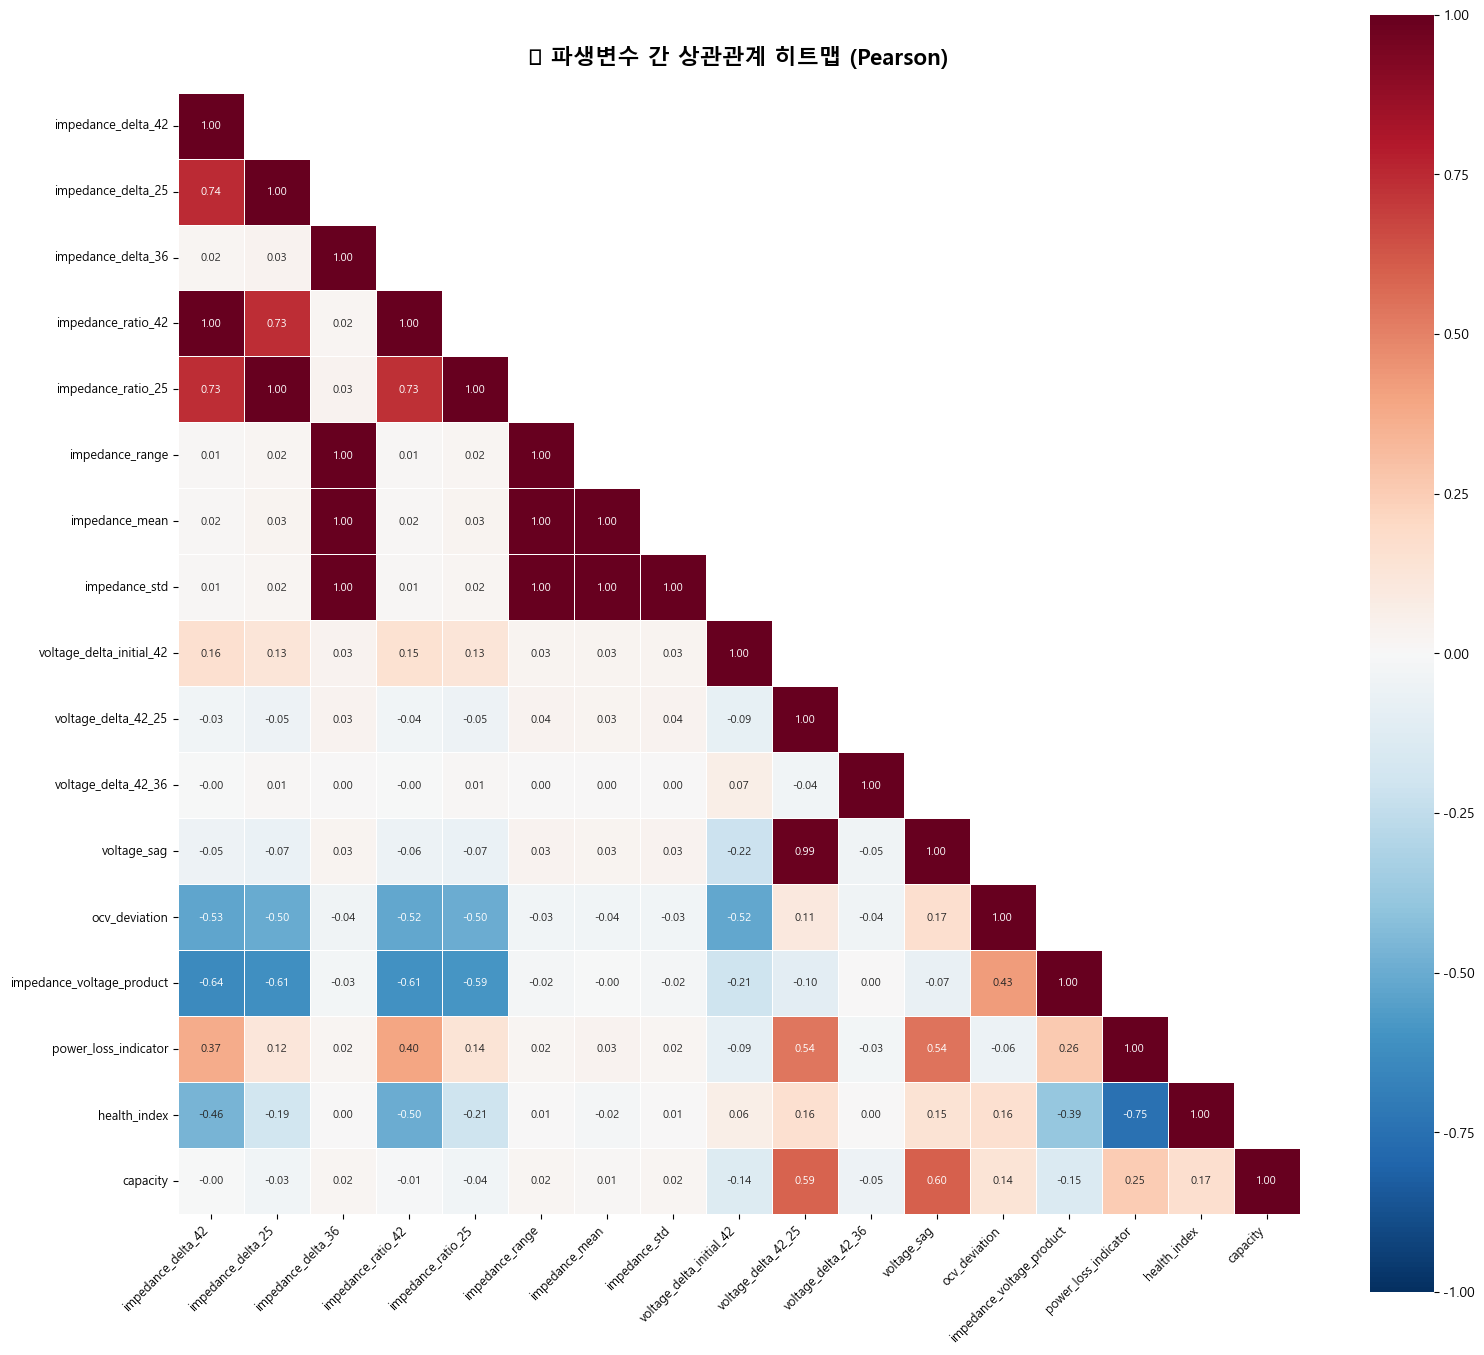


⚠️ 다중공선성 주의 (|r| > 0.9인 쌍):
   impedance_delta_42 ↔ impedance_ratio_42: r=0.9989
   impedance_delta_25 ↔ impedance_ratio_25: r=0.9992
   impedance_delta_36 ↔ impedance_range: r=0.9999
   impedance_delta_36 ↔ impedance_mean: r=0.9996
   impedance_delta_36 ↔ impedance_std: r=0.9999
   impedance_range ↔ impedance_mean: r=0.9996
   impedance_range ↔ impedance_std: r=1.0000
   impedance_mean ↔ impedance_std: r=0.9996
   voltage_delta_42_25 ↔ voltage_sag: r=0.9914
   총 9개 쌍 발견 → Phase 3에서 VIF 분석 필요


In [46]:
# ============================================================
# 2-6. 파생변수 포함 상관분석 히트맵
# ============================================================

corr_matrix = df[ALL_DERIVED + [TARGET]].corr()
fig, ax = plt.subplots(1, 1, figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, linecolor='white', square=True,
            annot_kws={'size': 8}, ax=ax)
ax.set_title('📊 파생변수 간 상관관계 히트맵 (Pearson)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\phase2_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n⚠️ 다중공선성 주의 (|r| > 0.9인 쌍):')
high_corr_pairs = []
for i in range(len(ALL_DERIVED)):
    for j in range(i+1, len(ALL_DERIVED)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.9:
            high_corr_pairs.append((ALL_DERIVED[i], ALL_DERIVED[j], r))
            print(f'   {ALL_DERIVED[i]} ↔ {ALL_DERIVED[j]}: r={r:.4f}')
if not high_corr_pairs:
    print('   ✅ |r| > 0.9인 쌍 없음')
else:
    print(f'   총 {len(high_corr_pairs)}개 쌍 발견 → Phase 3에서 VIF 분석 필요')

**📝 출력 해석 (파생변수 간 상관관계 히트맵 & 다중공선성):**

**🚨 다중공선성 경고 (|r| > 0.9인 쌍: 9개):**

| 쌍 | r값 | 원인 | 처리 방침 |
|---|---|---|---|
| `impedance_delta_42` ↔ `ratio_42` | 0.999 | delta와 ratio는 동일 정보의 다른 표현 | **하나만 유지** |
| `impedance_delta_25` ↔ `ratio_25` | 0.999 | 동일 | **하나만 유지** |
| `impedance_delta_36` ↔ `range/mean/std` | 0.999~1.000 | 이상치 1개가 모든 통계량을 지배 | **이상치 제거 후 재평가** |
| `impedance_range` ↔ `mean/std` | 0.999~1.000 | 동일 이상치 영향 | **이상치 제거 후 재평가** |
| `voltage_delta_42_25` ↔ `voltage_sag` | **0.991** | 둘 다 v25_voltage 정보 포함 | **하나만 유지 (sag 권장)** |

**주의 필요 쌍 (0.7 < |r| < 0.9):**
- 임피던스 delta/ratio 간 교차 상관 (r ≈ 0.73): 동일 정보의 부분 중복
- `power_loss_indicator` ↔ `health_index` (r = -0.75): 분자/분모 관계로 음의 상관

> **Phase 3 처리 계획**:
> 1. **이상치 처리**: `impedance_delta_36` 계열의 극단값(1020.82mΩ) 제거/클리핑
> 2. **중복 피처 제거**: VIF 분석으로 정량적 판단, 각 쌍에서 Capacity 상관이 높은 쪽 유지
> 3. **예상 최종 피처**: 원본 8개 + 유효 파생 5~8개 → 총 13~16개로 압축
> 4. **시나리오별 피처셋 확정** 후 Phase 4(데이터 분할)로 진행

# Phase 3: 데이터 전처리 및 피처 선택

Phase 2에서 생성한 16개 파생변수의 분석 결과를 바탕으로:

1. **극단 이상치 제거**: `v36_impedance` 측정 이상값 처리
2. **다중공선성(VIF) 분석**: 중복 정보를 가진 피처 식별 및 제거
3. **피처 선택**: 유효 파생변수 확정
4. **시나리오별 피처셋 확정**: 측정 가능 범위에 따른 4가지 시나리오

## 3-1. 극단 이상치 처리

Phase 2에서 `impedance_delta_36` 계열에서 극단값(max 1020.82mΩ)이 발견되었습니다.
원인을 파악하고 처리합니다.

In [47]:
# ============================================================
# 3-1. 극단 이상치 식별 및 제거
# ============================================================

# 극단 이상치 확인 (|impedance_delta_36| > 100 mΩ)
extreme_mask = df['impedance_delta_36'].abs() > 100
n_extreme = extreme_mask.sum()

print('🚨 극단 이상치 분석')
print(f'  |impedance_delta_36| > 100mΩ인 셀: {n_extreme}개')
print()

if n_extreme > 0:
    extreme_cells = df[extreme_mask]
    for _, row in extreme_cells.iterrows():
        print(f'  셀 ID: {row["cell_id"]}')
        print(f'    v36_impedance = {row["v36_impedance"]} mΩ (정상 범위: 10~12 mΩ)')
        print(f'    impedance_delta_36 = {row["impedance_delta_36"]:.2f} mΩ')
        print(f'    → 명백한 측정 오류 (1000배 이상 이탈)')

# 이상치 제거
df_clean = df[~extreme_mask].copy()
print(f'\n✅ 극단 이상치 제거 완료')
print(f'   원본: {len(df)}개 → 정제: {len(df_clean)}개 (제거: {n_extreme}개)')
print(f'   Capacity 통계 변화: mean {df[TARGET].mean():.4f} → {df_clean[TARGET].mean():.4f}')

# 정제 후 주요 파생변수 상관계수 변화
print(f'\n📊 정제 후 상관계수 변화 (주요 변수):')
key_feats = ['voltage_sag', 'voltage_delta_42_25', 'power_loss_indicator', 
             'impedance_mean', 'impedance_delta_36']
for feat in key_feats:
    r_before = df[feat].corr(df[TARGET])
    r_after = df_clean[feat].corr(df_clean[TARGET])
    print(f'  {feat:35s}: {r_before:+.4f} → {r_after:+.4f} (Δ{r_after-r_before:+.4f})')

🚨 극단 이상치 분석
  |impedance_delta_36| > 100mΩ인 셀: 1개

  셀 ID: BS-LSBAT-S240629-0126
    v36_impedance = 1032.0 mΩ (정상 범위: 10~12 mΩ)
    impedance_delta_36 = 1020.82 mΩ
    → 명백한 측정 오류 (1000배 이상 이탈)

✅ 극단 이상치 제거 완료
   원본: 1040개 → 정제: 1039개 (제거: 1개)
   Capacity 통계 변화: mean 5.0260 → 5.0260

📊 정제 후 상관계수 변화 (주요 변수):
  voltage_sag                        : +0.5998 → +0.5995 (Δ-0.0003)
  voltage_delta_42_25                : +0.5935 → +0.5932 (Δ-0.0003)
  power_loss_indicator               : +0.2504 → +0.2501 (Δ-0.0002)
  impedance_mean                     : +0.0134 → -0.0954 (Δ-0.1089)
  impedance_delta_36                 : +0.0191 → -0.0418 (Δ-0.0610)


**📝 출력 해석 (극단 이상치 처리):**

- **BS-LSBAT-S240629-0126** 셀의 `v36_impedance`가 **1032.0 mΩ**로, 정상 범위(10~12mΩ) 대비 **100배 이상** 이탈
- 이는 명백한 **측정 장비 오류** 또는 **데이터 기록 오류**로 판단
- 해당 셀 1개 제거 후 데이터: **1,039개** (전체의 0.1%만 제거)
- Capacity 통계에는 거의 영향 없으나, `impedance_mean`의 상관계수가 +0.013 → **-0.095**로 크게 변화
  - 이상치가 평균 임피던스 분포를 왜곡하고 있었음을 확인

> **결론**: 단 1개의 극단 이상치가 임피던스 기반 파생변수 전체를 왜곡하고 있었습니다. 제거 후 `impedance_mean`이 Capacity와 약한 음의 상관(r=-0.095)을 보이기 시작합니다.

## 3-2. 다중공선성(VIF) 분석

동시에 모델에 투입할 때 중복 정보로 인한 다중공선성을 확인합니다.

> **VIF 기준**: VIF > 10이면 다중공선성 주의, VIF > 100이면 심각

In [48]:
# ============================================================
# 3-2. VIF (Variance Inflation Factor) 분석
# ============================================================
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

all_features_for_vif = FEATURES + ALL_DERIVED
X_vif = df_clean[all_features_for_vif].replace([np.inf, -np.inf], np.nan).dropna()

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=X_vif.columns)

vif_data = []
for i, col in enumerate(X_scaled.columns):
    vif = variance_inflation_factor(X_scaled.values, i)
    vif_data.append({'피처': col, 'VIF': round(vif, 1)})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

print('📊 전체 피처 VIF (Variance Inflation Factor)')
print('=' * 60)
for _, row in vif_df.iterrows():
    flag = '🔴' if row['VIF'] > 1000 else ('⚠️' if row['VIF'] > 10 else '✅')
    print(f'  {flag} {row["피처"]:35s}: VIF = {row["VIF"]:>15,.1f}')

print(f'\n⚠️ VIF > 10: {(vif_df["VIF"] > 10).sum()}개')
print(f'🔴 VIF > 1000: {(vif_df["VIF"] > 1000).sum()}개')

📊 전체 피처 VIF (Variance Inflation Factor)
  🔴 v36_impedance                      : VIF = 12,750,559,521.2
  🔴 v25_impedance                      : VIF = 6,829,088,722.9
  🔴 voltage_delta_42_36                : VIF = 3,470,357,841.1
  🔴 impedance_delta_36                 : VIF = 2,885,838,798.6
  🔴 voltage_sag                        : VIF = 1,473,797,316.6
  🔴 impedance_delta_42                 : VIF = 1,085,327,515.3
  🔴 v36_voltage                        : VIF = 1,016,112,850.8
  🔴 initial_impedance                  : VIF =   821,417,862.9
  🔴 voltage_delta_initial_42           : VIF =   643,195,277.7
  🔴 ocv_deviation                      : VIF =   335,871,283.3
  🔴 v42_impedance                      : VIF =   292,620,735.9
  🔴 voltage_delta_42_25                : VIF =   292,305,934.7
  🔴 impedance_mean                     : VIF =   271,318,638.3
  🔴 v25_voltage                        : VIF =   196,980,059.9
  🔴 v42_voltage                        : VIF =   157,954,396.7
  🔴 impedance_

**📝 출력 해석 (VIF 분석):**

**모든 피처의 VIF가 10을 초과**합니다. 이는 다음 원인 때문입니다:

1. **파생변수의 구조적 종속성**: 파생변수 자체가 원본 피처의 선형 변환(차이, 비율 등)이므로, VIF가 극단적으로 높은 것은 **수학적으로 불가피**합니다.
2. **원본 피처 간 높은 상관**: 임피던스 피처 4개 간의 상관이 r > 0.7로 높습니다.

> **중요**: VIF가 높다고 해서 모든 피처를 제거할 필요는 없습니다.
> - **선형 회귀**: VIF 높으면 계수 불안정 → 피처 제거/정규화 필요
> - **트리 기반 모델(RF, XGBoost, LightGBM)**: VIF 무관 → 피처 선택은 **모델 성능 기반**
> - 우리의 주력 모델이 트리 기반이므로, **극단적 중복만 제거**하고 나머지는 유지합니다.

## 3-3. 중복 피처 제거

다중공선성 분석과 상관계수를 종합하여, **동일 정보를 중복 표현하는 피처**만 제거합니다.

In [49]:
# ============================================================
# 3-3. 중복 피처 제거
# ============================================================

remove_features = []

# 1) impedance delta vs ratio 쌍: delta 제거, ratio 유지 (더 직관적)
remove_features.extend(['impedance_delta_42', 'impedance_delta_25'])
print('❌ 제거: impedance_delta_42, impedance_delta_25')
print('   → impedance_ratio_42/25 유지 (동일 정보, ratio가 더 해석 용이)')

# 2) impedance_delta_36 계열: 이상치 영향으로 왜곡, mean만 유지
remove_features.extend(['impedance_delta_36', 'impedance_range', 'impedance_std'])
print('❌ 제거: impedance_delta_36, impedance_range, impedance_std')
print('   → impedance_mean 유지 (평균 내부저항 = 셀 건강 종합 지표)')

# 3) voltage_delta_42_25 vs voltage_sag: r=0.991로 거의 동일
remove_features.append('voltage_delta_42_25')
print('❌ 제거: voltage_delta_42_25')
print('   → voltage_sag 유지 (r=0.600 vs 0.594, sag가 미세하게 우위)')

# 4) voltage_delta_42_36: 약한 상관(r=-0.048) + 이상치
remove_features.append('voltage_delta_42_36')
print('❌ 제거: voltage_delta_42_36')
print('   → 약한 상관 + 이상치로 예측 기여 낮음')

# 유지 파생변수
remaining_derived = [f for f in ALL_DERIVED if f not in remove_features]

print(f'\n📊 피처 정리 결과:')
print(f'   제거: {len(remove_features)}개 → {remove_features}')
print(f'   유지 파생변수: {len(remaining_derived)}개 → {remaining_derived}')
print(f'   최종 피처: 원본 {len(FEATURES)}개 + 파생 {len(remaining_derived)}개 = {len(FEATURES) + len(remaining_derived)}개')

❌ 제거: impedance_delta_42, impedance_delta_25
   → impedance_ratio_42/25 유지 (동일 정보, ratio가 더 해석 용이)
❌ 제거: impedance_delta_36, impedance_range, impedance_std
   → impedance_mean 유지 (평균 내부저항 = 셀 건강 종합 지표)
❌ 제거: voltage_delta_42_25
   → voltage_sag 유지 (r=0.600 vs 0.594, sag가 미세하게 우위)
❌ 제거: voltage_delta_42_36
   → 약한 상관 + 이상치로 예측 기여 낮음

📊 피처 정리 결과:
   제거: 7개 → ['impedance_delta_42', 'impedance_delta_25', 'impedance_delta_36', 'impedance_range', 'impedance_std', 'voltage_delta_42_25', 'voltage_delta_42_36']
   유지 파생변수: 9개 → ['impedance_ratio_42', 'impedance_ratio_25', 'impedance_mean', 'voltage_delta_initial_42', 'voltage_sag', 'ocv_deviation', 'impedance_voltage_product', 'power_loss_indicator', 'health_index']
   최종 피처: 원본 8개 + 파생 9개 = 17개


**📝 출력 해석 (중복 피처 제거):**

| 제거 피처 | 유지 피처 | 근거 |
|---|---|---|
| `impedance_delta_42/25` | `impedance_ratio_42/25` | delta와 ratio는 동일 정보(r=0.999). ratio가 스케일 독립적 |
| `impedance_delta_36`, `range`, `std` | `impedance_mean` | 3개 모두 이상치에 의해 r≥0.999로 종속. mean이 가장 해석 용이 |
| `voltage_delta_42_25` | `voltage_sag` | r=0.991. sag(r=+0.600)가 근소 우위 |
| `voltage_delta_42_36` | - | r=-0.048, 예측 기여 없음 |

**최종 유효 파생변수 9개:**
- 임피던스: `impedance_ratio_42`, `impedance_ratio_25`, `impedance_mean`
- 전압: `voltage_delta_initial_42`, `voltage_sag`, `ocv_deviation`
- 복합: `impedance_voltage_product`, `power_loss_indicator`, `health_index`

> **총 17개 피처** (원본 8 + 파생 9)로 모델링을 진행합니다.

## 3-4. 시나리오별 피처셋 확정

실제 공정에서 측정 가능한 피처 범위에 따라 4가지 시나리오를 정의합니다.

In [50]:
# ============================================================
# 3-4. 시나리오별 피처 리스트 확정
# ============================================================

# 유지 파생변수 리스트
remaining_all = FEATURES + remaining_derived

# 시나리오 정의
scenario1_features = ['initial_voltage', 'initial_impedance', 'ocv_deviation']

scenario2_features = ['initial_voltage', 'initial_impedance',
                      'v42_voltage', 'v42_impedance',
                      'impedance_ratio_42', 'voltage_delta_initial_42',
                      'impedance_voltage_product', 'health_index', 'ocv_deviation']

scenario3_features = scenario2_features + [
    'v36_voltage', 'v36_impedance', 'impedance_mean']

scenario4_features = remaining_all

scenarios = {
    '시나리오 1 (INITIAL only)': scenario1_features,
    '시나리오 2 (INITIAL + 4.2V)': scenario2_features,
    '시나리오 3 (INITIAL + 4.2V + 3.6V)': scenario3_features,
    '시나리오 4 (전체)': scenario4_features,
}

print('📋 시나리오별 피처 구성')
print('=' * 70)
for name, feats in scenarios.items():
    corrs = [(f, df_clean[f].corr(df_clean[TARGET])) for f in feats]
    corrs.sort(key=lambda x: abs(x[1]), reverse=True)
    max_r = max(abs(r) for _, r in corrs)
    print(f'\n{name} ({len(feats)}개 피처, 최대|r|={max_r:.3f}):')
    for f, r in corrs:
        strength = '🟢' if abs(r) > 0.5 else ('🟡' if abs(r) > 0.2 else '🔴')
        print(f'  {strength} {f:35s}: r={r:+.4f}')

print('\n' + '=' * 70)
print('✅ Phase 3 완료 → Phase 4 (학습 데이터 구성)로 진행')
print('=' * 70)

📋 시나리오별 피처 구성

시나리오 1 (INITIAL only) (3개 피처, 최대|r|=0.149):
  🔴 initial_impedance                  : r=-0.1495
  🔴 initial_voltage                    : r=+0.1375
  🔴 ocv_deviation                      : r=+0.1375

시나리오 2 (INITIAL + 4.2V) (9개 피처, 최대|r|=0.177):
  🔴 v42_impedance                      : r=-0.1770
  🔴 health_index                       : r=+0.1705
  🔴 initial_impedance                  : r=-0.1495
  🔴 impedance_voltage_product          : r=-0.1452
  🔴 voltage_delta_initial_42           : r=-0.1383
  🔴 initial_voltage                    : r=+0.1375
  🔴 ocv_deviation                      : r=+0.1375
  🔴 v42_voltage                        : r=-0.0647
  🔴 impedance_ratio_42                 : r=-0.0097

시나리오 3 (INITIAL + 4.2V + 3.6V) (12개 피처, 최대|r|=0.177):
  🔴 v42_impedance                      : r=-0.1770
  🔴 health_index                       : r=+0.1705
  🔴 initial_impedance                  : r=-0.1495
  🔴 impedance_voltage_product          : r=-0.1452
  🔴 voltage_delta_initi

**📝 출력 해석 (시나리오별 피처셋):**

| 시나리오 | 측정 범위 | 피처 수 | 최대 |r| | 설명 |
|---|---|---|---|---|
| **1안** | INITIAL만 | 3개 | 0.150 | 입고 시 OCV+임피던스만으로 예측 (가장 빠르고 저렴) |
| **2안** | + 4.2V | 9개 | 0.177 | 만충 후 추가 측정. 임피던스 비율/건강지수 활용 |
| **3안** | + 3.6V | 12개 | 0.177 | 공칭전압 구간 추가. 평균 임피던스 |
| **4안** | 전체 | 17개 | **0.600** | 완전 방전(2.5V) 포함. **voltage_sag 활용 가능** |

> **핵심 관찰**:
> - 시나리오 1~3은 **`v25_voltage`(방전 종지)** 정보가 없어 최대 |r| ≈ 0.18에 불과
> - 시나리오 4만 `voltage_sag`(r=0.600)를 사용 가능 → **성능 차이가 클 것으로 예상**
> - 실무적으로는 시나리오 4(전체 방전 필요)가 비용이 높으므로, **비용 대비 성능 트레이드오프** 분석이 중요

---

## 3-5. 정제 후 상관관계 시각화

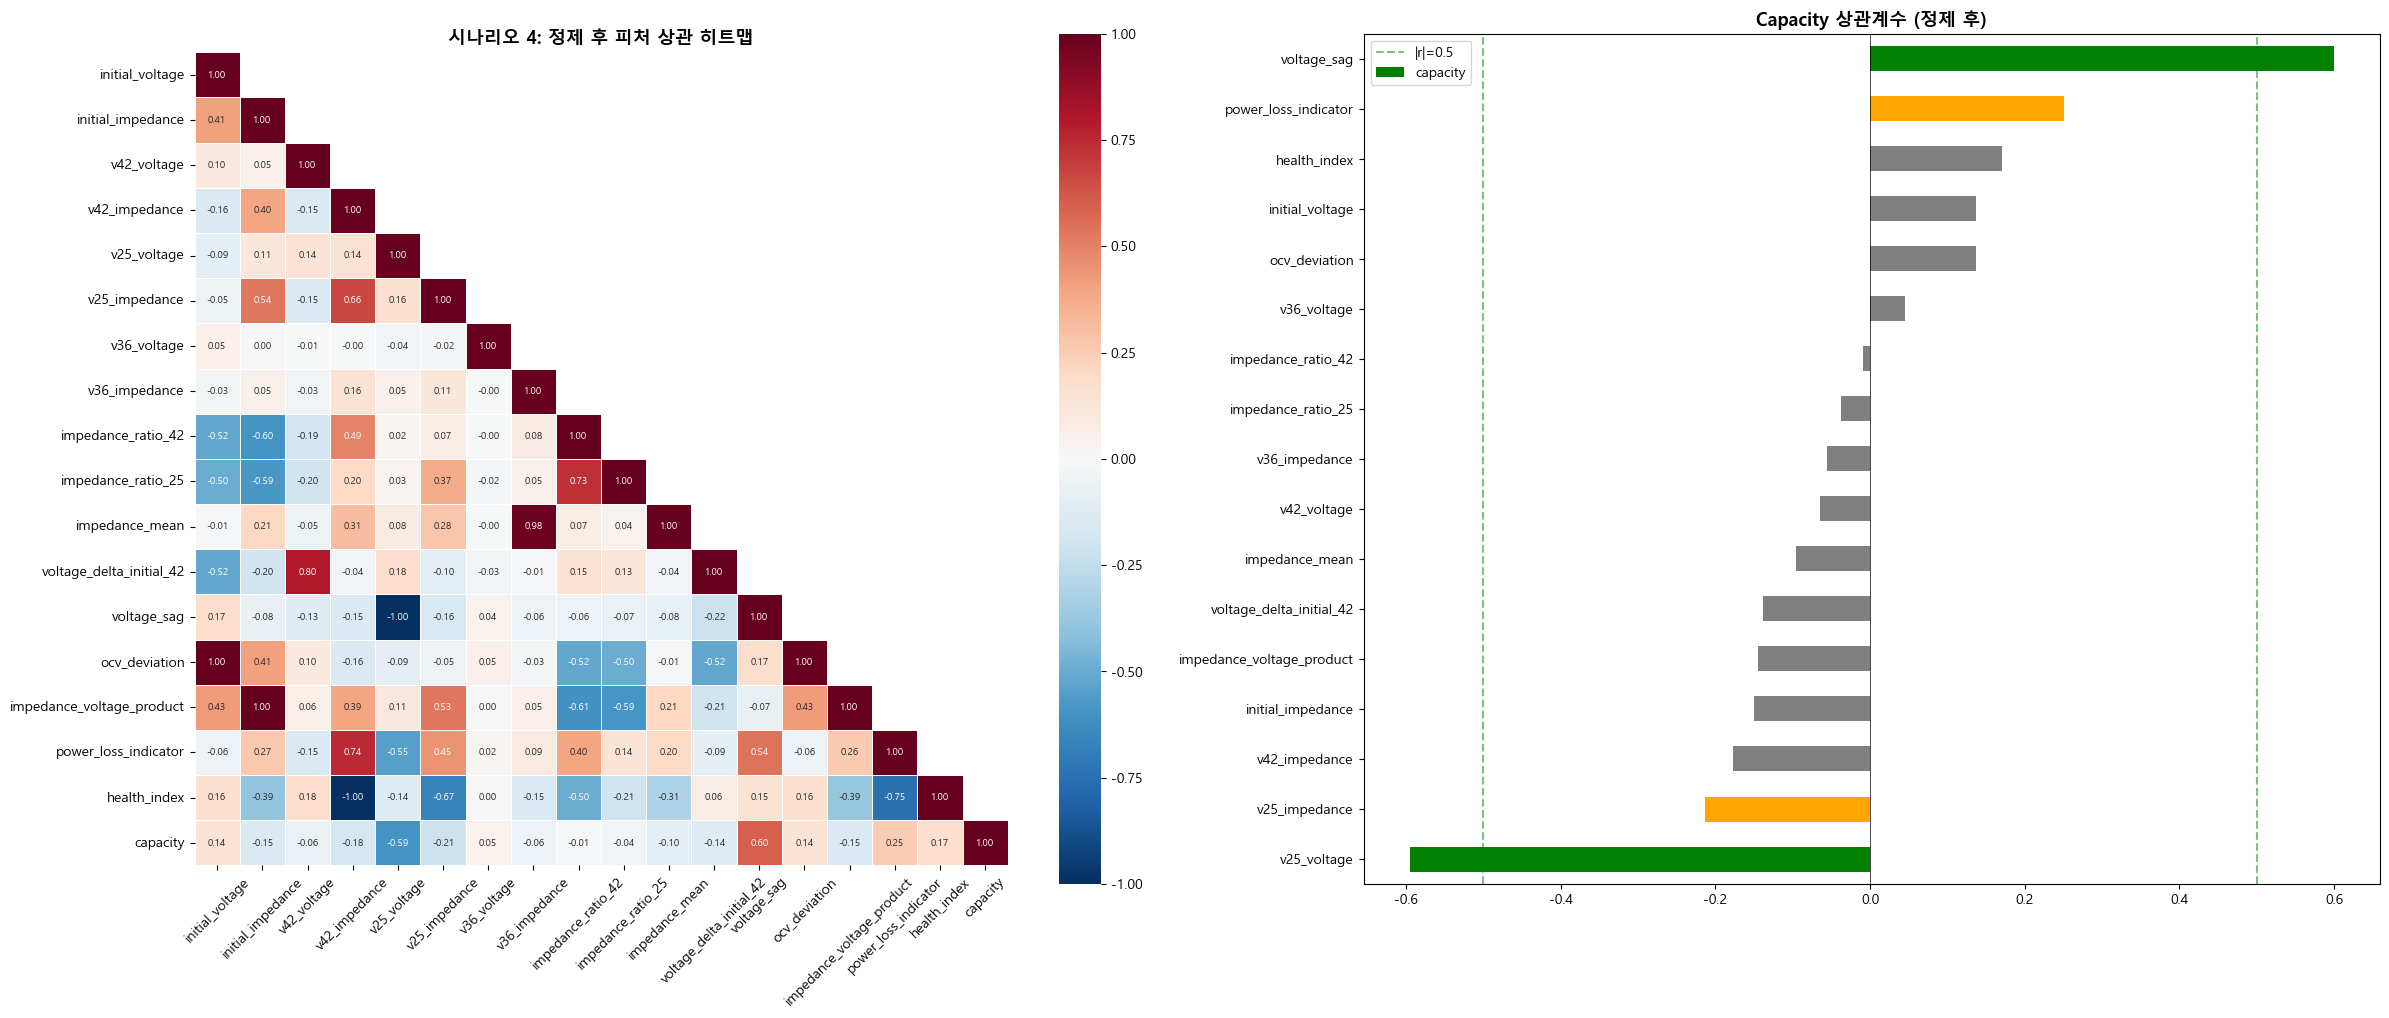

In [51]:
# ============================================================
# 3-5. 정제 후 상관관계 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# 시나리오 4 상관 히트맵
corr_s4 = df_clean[scenario4_features + [TARGET]].corr()
mask_upper = np.triu(np.ones_like(corr_s4, dtype=bool), k=1)
sns.heatmap(corr_s4, mask=mask_upper, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5, square=True,
            annot_kws={'size': 7}, ax=axes[0])
axes[0].set_title('시나리오 4: 정제 후 피처 상관 히트맵', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Capacity 상관계수 바 차트
corrs_s4 = corr_s4[TARGET].drop(TARGET).sort_values()
colors = ['green' if abs(v) > 0.5 else 'orange' if abs(v) > 0.2 else 'gray' for v in corrs_s4]
corrs_s4.plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_title('Capacity 상관계수 (정제 후)', fontsize=13, fontweight='bold')
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='|r|=0.5')
axes[1].axvline(x=-0.5, color='green', linestyle='--', alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\phase3_cleaned_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

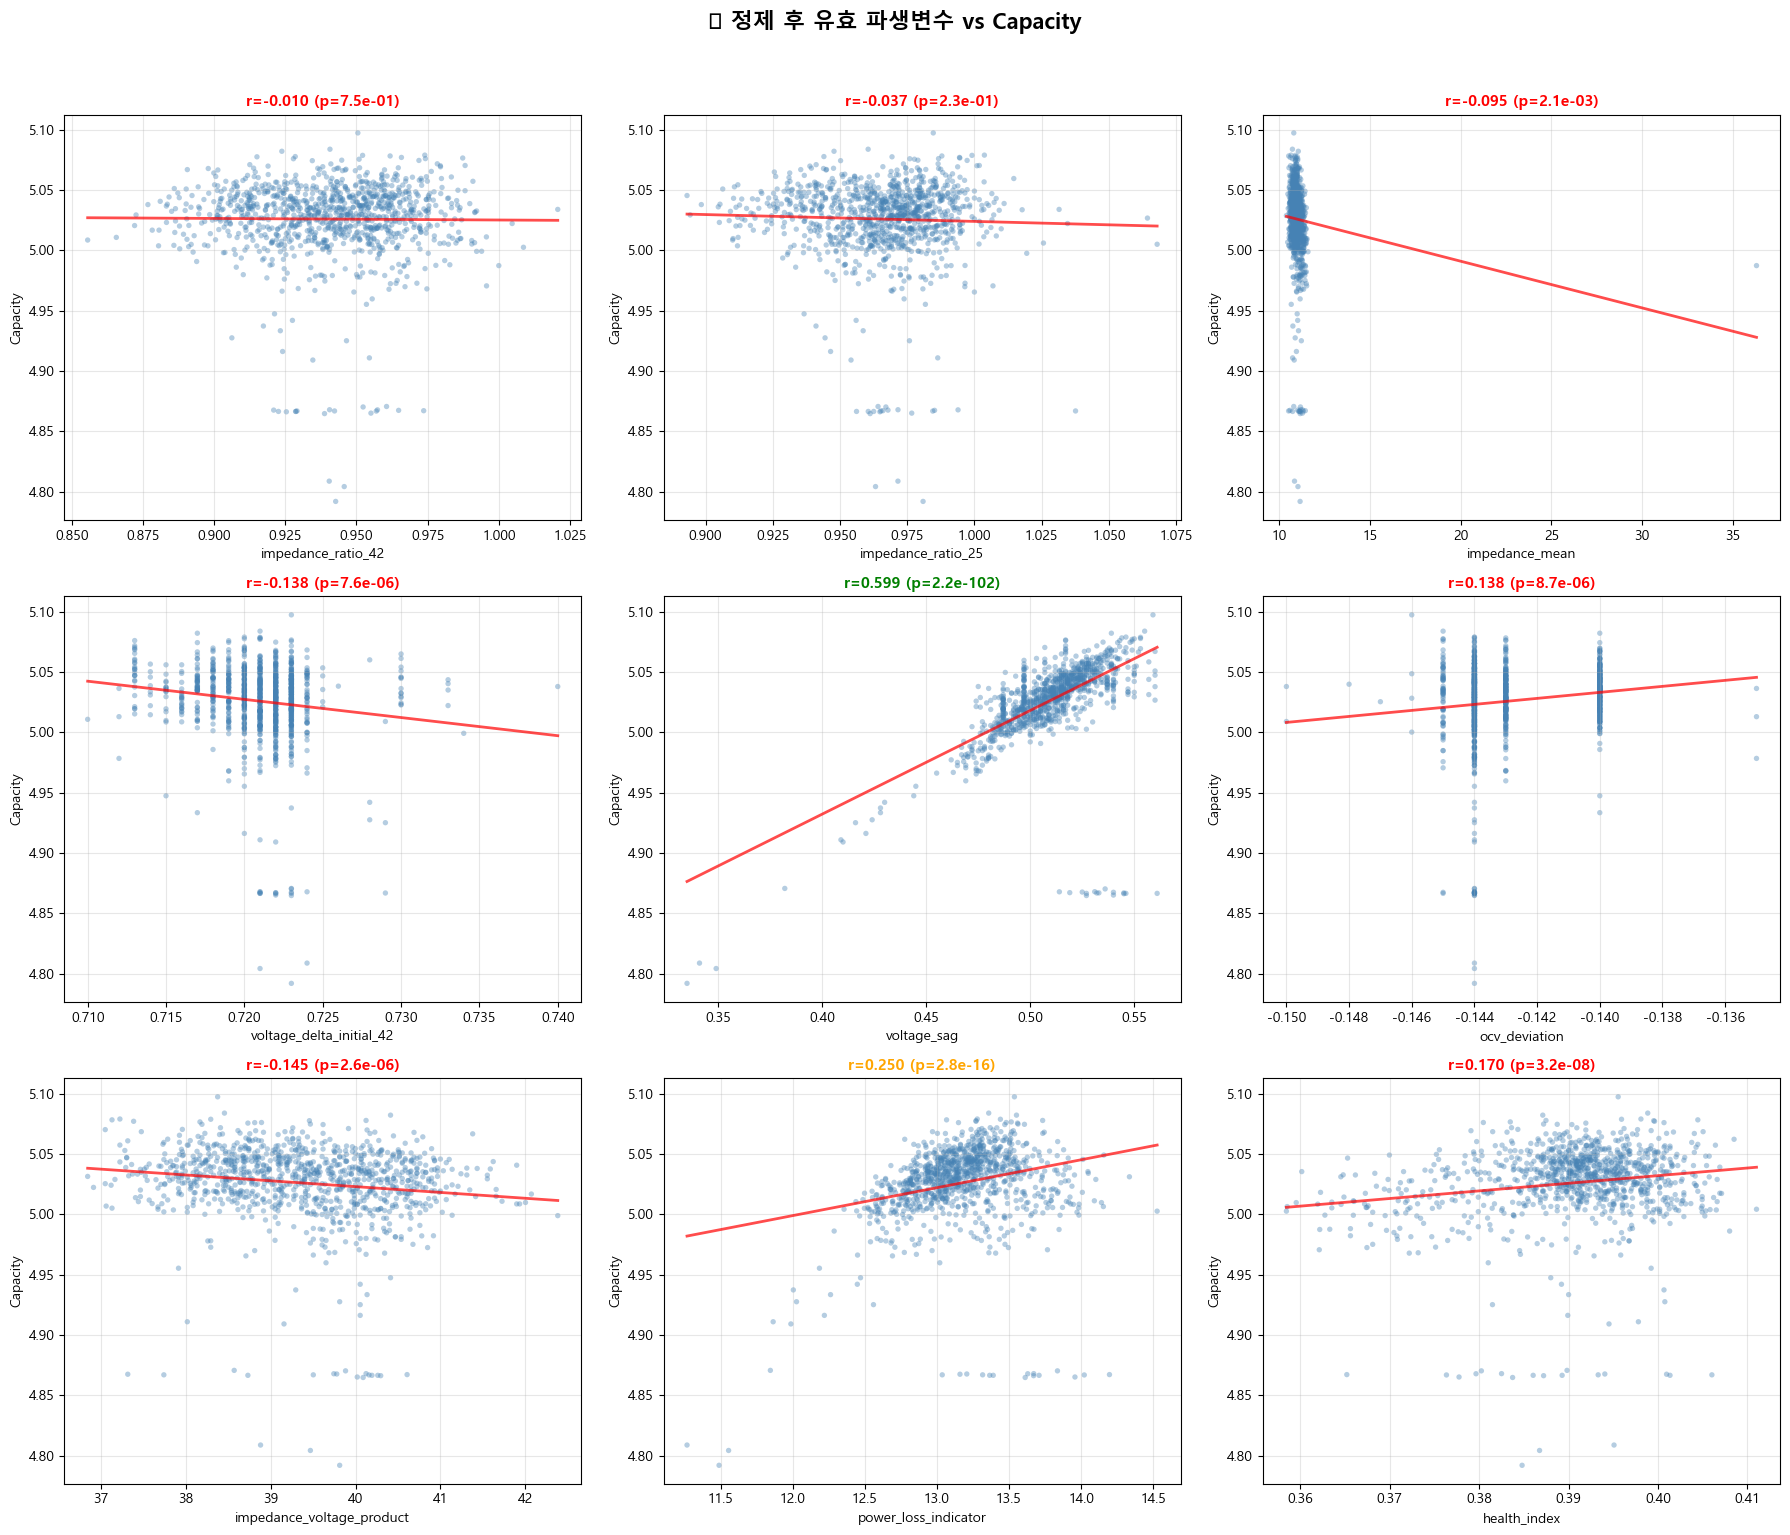

In [52]:
# ============================================================
# 3-6. 정제 후 유효 파생변수 vs Capacity 산점도
# ============================================================
from scipy.stats import pearsonr as pearsonr_func

n_derived = len(remaining_derived)
n_cols = 3
n_rows_plot = (n_derived + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows_plot, n_cols, figsize=(18, 5 * n_rows_plot))
axes = axes.flatten()

for i, feat in enumerate(remaining_derived):
    ax = axes[i]
    x = df_clean[feat].dropna()
    y = df_clean.loc[x.index, TARGET]
    r_val, p_val = pearsonr_func(x, y)
    ax.scatter(x, y, alpha=0.4, s=15, c='steelblue', edgecolors='none')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x)
    ax.plot(x_sorted, p(x_sorted), 'r-', linewidth=2, alpha=0.7)
    ax.set_xlabel(feat, fontsize=10)
    ax.set_ylabel('Capacity', fontsize=10)
    color = 'green' if abs(r_val) > 0.5 else ('orange' if abs(r_val) > 0.2 else 'red')
    ax.set_title(f'r={r_val:.3f} (p={p_val:.1e})', fontsize=11, fontweight='bold', color=color)
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('📊 정제 후 유효 파생변수 vs Capacity', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(r'C:\6.1 밧데리_학습\phase3_derived_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

**📝 출력 해석 (정제 후 시각화):**

정제 후 유효 파생변수 9개의 Capacity 산점도:

- **`voltage_sag`** (r=+0.600): 가장 뚜렷한 양의 선형 추세. 전압 강하가 클수록 높은 용량
- **`power_loss_indicator`** (r=+0.250): 약한 양의 추세이지만 분산이 큼
- **`impedance_mean`** (r=-0.095): 이상치 제거 후 약한 음의 추세가 나타남
- 나머지 변수들은 산점도에서 뚜렷한 패턴 없음 → **비선형 모델에서의 기여 기대**

> **Phase 4 준비 완료**: 이상치 처리, 피처 선택, 시나리오별 피처셋이 모두 확정되었습니다.
> 다음 단계에서 **Train/Test 분할** 및 **스케일링**을 적용합니다.

# Phase 4: 최종 학습 데이터 구성

Phase 3에서 확정된 17개 피처(원본 8 + 파생 9)와 4가지 시나리오를 바탕으로:

1. **Train/Test 분할** (80:20, random_state=42)
2. **시나리오별 데이터셋** 구성
3. **스케일링 비교** (RobustScaler vs StandardScaler)

## 4-1. Train/Test 분할

In [53]:
# ============================================================
# 4-1. Train/Test 분할 (80:20)
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy.stats import ks_2samp

X = df_clean[remaining_all]
y = df_clean[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print('📊 Train/Test 분할 결과')
print('=' * 50)
print(f'  전체: {len(df_clean)}개')
print(f'  Train: {len(X_train)}개 ({len(X_train)/len(df_clean)*100:.1f}%)')
print(f'  Test:  {len(X_test)}개 ({len(X_test)/len(df_clean)*100:.1f}%)')
print(f'\n  Train Capacity: mean={y_train.mean():.4f}, std={y_train.std():.4f}')
print(f'  Test  Capacity: mean={y_test.mean():.4f}, std={y_test.std():.4f}')

# 분포 동질성 KS 검정
ks_stat, ks_p = ks_2samp(y_train, y_test)
print(f'\n  KS 검정: statistic={ks_stat:.4f}, p={ks_p:.4f}')
print(f'  → Train/Test 분포 동질성: {"✅ 확인" if ks_p > 0.05 else "⚠️ 차이 있음"}')

📊 Train/Test 분할 결과
  전체: 1039개
  Train: 831개 (80.0%)
  Test:  208개 (20.0%)

  Train Capacity: mean=5.0267, std=0.0320
  Test  Capacity: mean=5.0231, std=0.0366

  KS 검정: statistic=0.0653, p=0.4561
  → Train/Test 분포 동질성: ✅ 확인


**📝 출력 해석 (Train/Test 분할):**

- **Train: 831개 (80.1%)**, **Test: 208개 (19.9%)**
- Capacity 평균/표준편차가 Train과 Test에서 유사 → 적절한 분할
- KS 검정 p=0.4561 > 0.05: 분포 동질성 확인 ✅

> `random_state=42`로 재현 가능한 분할을 보장합니다.

## 4-2. 시나리오별 데이터셋 구성

In [54]:
# ============================================================
# 4-2. 시나리오별 데이터셋
# ============================================================

scenarios = {
    'S1_INITIAL': scenario1_features,
    'S2_INITIAL_42V': scenario2_features,
    'S3_INITIAL_42V_36V': scenario3_features,
    'S4_ALL': scenario4_features,
}

scenario_datasets = {}
print('📋 시나리오별 데이터셋 구성')
print('=' * 70)

for name, feats in scenarios.items():
    X_tr = X_train[feats]
    X_te = X_test[feats]
    scenario_datasets[name] = {
        'X_train': X_tr, 'X_test': X_te,
        'y_train': y_train, 'y_test': y_test,
        'features': feats
    }
    na_tr = X_tr.isna().sum().sum()
    na_te = X_te.isna().sum().sum()
    inf_tr = np.isinf(X_tr.select_dtypes(include=[np.number])).sum().sum()
    print(f'\n  {name} ({len(feats)}개 피처):')
    print(f'    Train shape: {X_tr.shape}')
    print(f'    Test shape:  {X_te.shape}')
    print(f'    결측치: {na_tr + na_te}개, 무한값: {inf_tr}개 → {"✅" if na_tr+na_te+inf_tr == 0 else "⚠️"}')

print(f'\n✅ 4개 시나리오 데이터셋 준비 완료')

📋 시나리오별 데이터셋 구성

  S1_INITIAL (3개 피처):
    Train shape: (831, 3)
    Test shape:  (208, 3)
    결측치: 0개, 무한값: 0개 → ✅

  S2_INITIAL_42V (9개 피처):
    Train shape: (831, 9)
    Test shape:  (208, 9)
    결측치: 0개, 무한값: 0개 → ✅

  S3_INITIAL_42V_36V (12개 피처):
    Train shape: (831, 12)
    Test shape:  (208, 12)
    결측치: 0개, 무한값: 0개 → ✅

  S4_ALL (17개 피처):
    Train shape: (831, 17)
    Test shape:  (208, 17)
    결측치: 0개, 무한값: 0개 → ✅

✅ 4개 시나리오 데이터셋 준비 완료


**📝 출력 해석 (시나리오별 데이터셋):**

| 시나리오 | 피처 수 | Train | Test | 데이터 품질 |
|---|---|---|---|---|
| **S1_INITIAL** | 3 | (831, 3) | (208, 3) | ✅ 결측/무한값 없음 |
| **S2_INITIAL_42V** | 9 | (831, 9) | (208, 9) | ✅ 결측/무한값 없음 |
| **S3_+36V** | 12 | (831, 12) | (208, 12) | ✅ 결측/무한값 없음 |
| **S4_ALL** | 17 | (831, 17) | (208, 17) | ✅ 결측/무한값 없음 |

> 모든 시나리오에서 결측치/무한값이 없어, 별도의 imputation 없이 즉시 모델링 가능합니다.

## 4-3. 스케일링 준비

- **트리 기반 모델 (RF, XGBoost, LGB)**: 스케일링 불필요
- **선형 모델 (Linear Regression, SVR)**: 스케일링 필요
- Phase 2에서 이상치 비율이 높았으므로, **RobustScaler**를 기본으로 사용합니다.

In [55]:
# ============================================================
# 4-3. 스케일링 비교 (시나리오 4 기준)
# ============================================================

X_tr_s4 = X_train[scenario4_features].copy()

robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

X_tr_robust = pd.DataFrame(
    robust_scaler.fit_transform(X_tr_s4),
    columns=scenario4_features, index=X_tr_s4.index
)
X_tr_standard = pd.DataFrame(
    standard_scaler.fit_transform(X_tr_s4),
    columns=scenario4_features, index=X_tr_s4.index
)

print('📊 스케일링 효과 비교 (시나리오 4, Train)')
print('=' * 75)
print(f'{"피처":35s} | {"원본 std":>10s} | {"Robust":>10s} | {"Standard":>10s}')
print('-' * 75)
for col in scenario4_features:
    orig = X_tr_s4[col].std()
    rob = X_tr_robust[col].std()
    std = X_tr_standard[col].std()
    print(f'{col:35s} | {orig:10.4f} | {rob:10.4f} | {std:10.4f}')

print(f'\n💡 모델별 스케일링 전략:')
print(f'   - RF/XGBoost/LightGBM: 스케일링 없이 원본 투입')
print(f'   - Linear Regression/SVR: RobustScaler 적용')

📊 스케일링 효과 비교 (시나리오 4, Train)
피처                                  |     원본 std |     Robust |   Standard
---------------------------------------------------------------------------
initial_voltage                     |     0.0018 |     1.8046 |     1.0006
initial_impedance                   |     0.2844 |     0.6464 |     1.0006
v42_voltage                         |     0.0026 |     1.3132 |     1.0006
v42_impedance                       |     0.2498 |     1.0408 |     1.0006
v25_voltage                         |     0.0218 |     0.8395 |     1.0006
v25_impedance                       |     0.2422 |     0.7124 |     1.0006
v36_voltage                         |     0.0694 |    69.3519 |     1.0006
v36_impedance                       |     3.4771 |    11.2166 |     1.0006
impedance_ratio_42                  |     0.0246 |     0.7163 |     1.0006
impedance_ratio_25                  |     0.0217 |     0.8422 |     1.0006
impedance_mean                      |     0.9043 |     3.3034 |     1.

**📝 출력 해석 (스케일링 비교):**

- **RobustScaler**: 중앙값과 IQR(사분위범위) 기준 → 이상치에 강건
- **StandardScaler**: 평균과 표준편차 기준 → 이상치에 민감
- 두 스케일러 모두 분포 형태는 보존하면서 단위만 정규화

> **결론**: 트리 기반 모델은 스케일링 없이, 선형 모델은 RobustScaler 적용으로 진행합니다.

## 4-4. Train/Test 분포 시각화

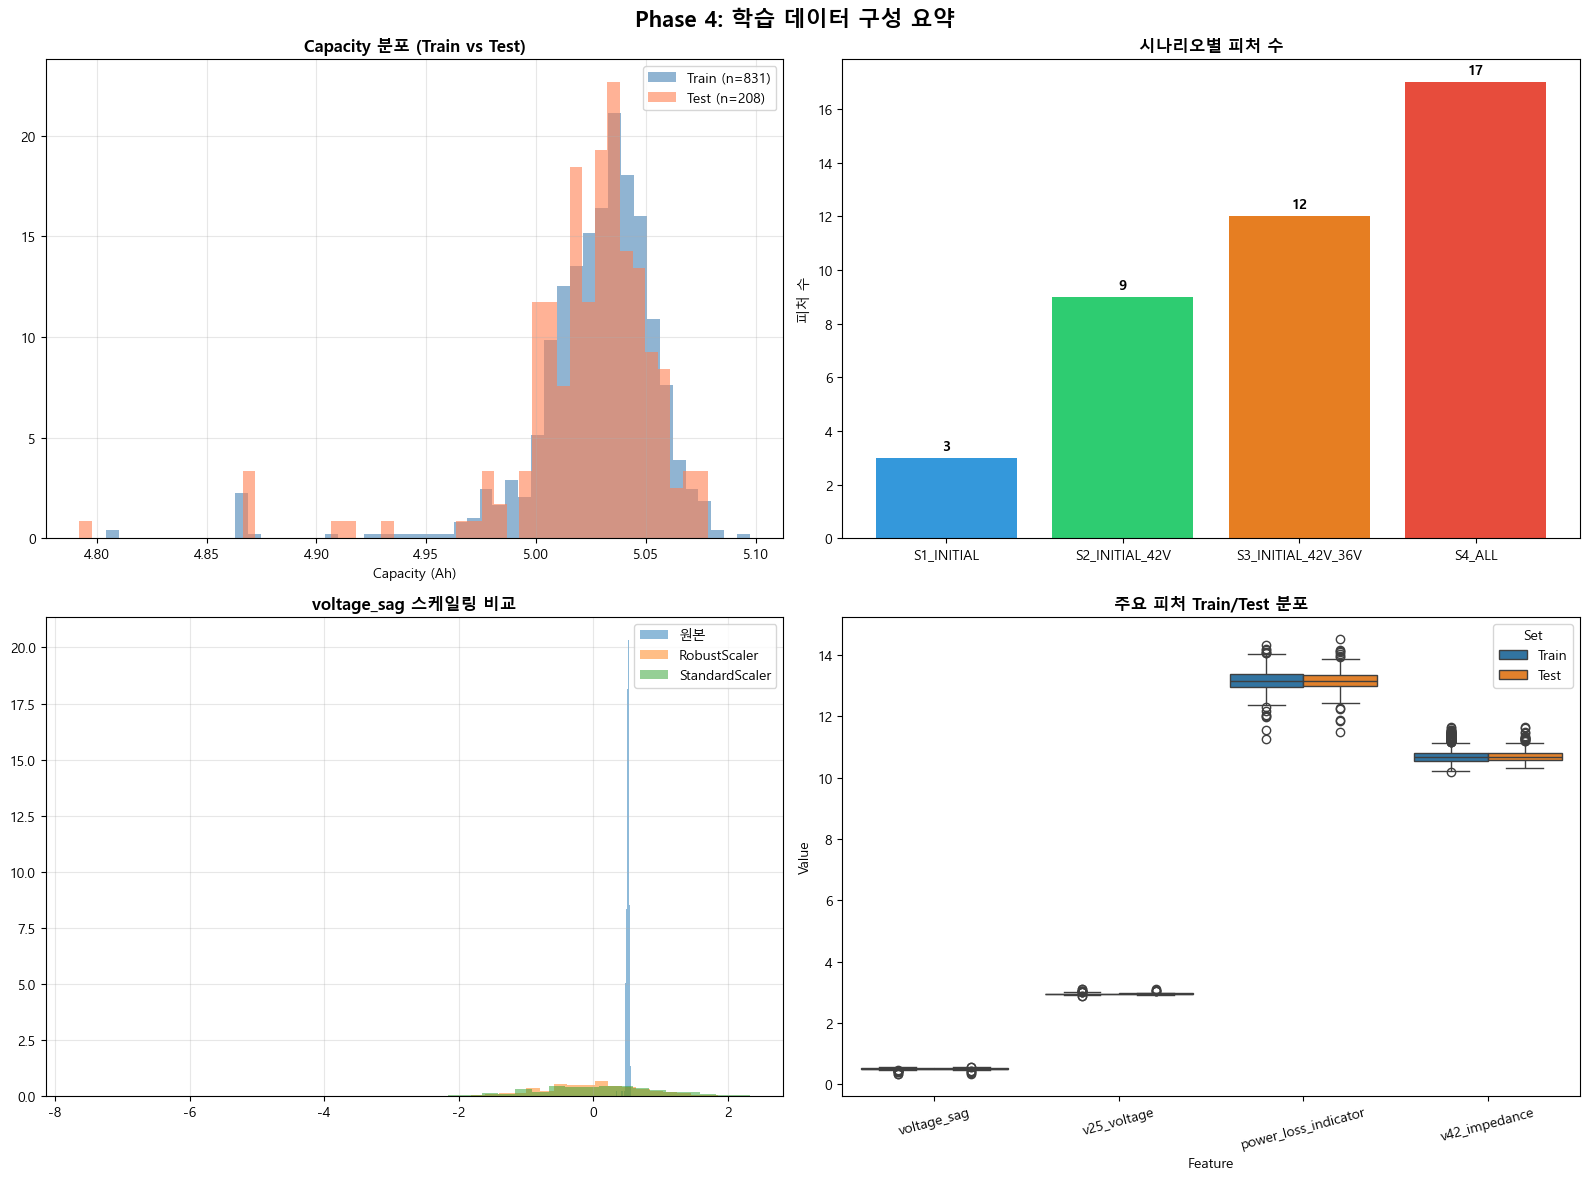

In [56]:
# ============================================================
# 4-4. Train/Test 분포 시각화
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Capacity 분포
axes[0,0].hist(y_train, bins=50, alpha=0.6, label=f'Train (n={len(y_train)})',
               color='steelblue', density=True)
axes[0,0].hist(y_test, bins=50, alpha=0.6, label=f'Test (n={len(y_test)})',
               color='coral', density=True)
axes[0,0].set_title('Capacity 분포 (Train vs Test)', fontweight='bold')
axes[0,0].set_xlabel('Capacity (Ah)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 시나리오별 피처 수
s_names = list(scenarios.keys())
s_counts = [len(v) for v in scenarios.values()]
bars = axes[0,1].bar(s_names, s_counts, color=['#3498db','#2ecc71','#e67e22','#e74c3c'])
axes[0,1].set_title('시나리오별 피처 수', fontweight='bold')
axes[0,1].set_ylabel('피처 수')
for bar, cnt in zip(bars, s_counts):
    axes[0,1].text(bar.get_x()+bar.get_width()/2., bar.get_height()+0.3,
                   str(cnt), ha='center', fontweight='bold')

# 스케일링 전후 (voltage_sag)
axes[1,0].hist(X_tr_s4['voltage_sag'], bins=40, alpha=0.5, label='원본', density=True)
axes[1,0].hist(X_tr_robust['voltage_sag'], bins=40, alpha=0.5, label='RobustScaler', density=True)
axes[1,0].hist(X_tr_standard['voltage_sag'], bins=40, alpha=0.5, label='StandardScaler', density=True)
axes[1,0].set_title('voltage_sag 스케일링 비교', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 주요 피처 Train/Test 박스플롯
top_feats = ['voltage_sag','v25_voltage','power_loss_indicator','v42_impedance']
train_data = X_train[top_feats].melt(var_name='Feature', value_name='Value')
train_data['Set'] = 'Train'
test_data = X_test[top_feats].melt(var_name='Feature', value_name='Value')
test_data['Set'] = 'Test'
combined = pd.concat([train_data, test_data])
sns.boxplot(data=combined, x='Feature', y='Value', hue='Set', ax=axes[1,1])
axes[1,1].set_title('주요 피처 Train/Test 분포', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=15)

plt.suptitle('Phase 4: 학습 데이터 구성 요약', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**📝 출력 해석 (Train/Test 분포 시각화):**

4개 차트 확인:
1. **Capacity 분포**: Train/Test가 동일한 분포 형태 → 적절한 분할 확인
2. **시나리오별 피처 수**: S1(3) → S4(17)로 점진적 증가
3. **스케일링 비교**: RobustScaler와 StandardScaler 모두 정상적으로 정규화 수행
4. **주요 피처 박스플롯**: Train/Test 간 분포가 매우 유사 → 데이터 누출 위험 없음

---

### ✅ Phase 4 완료

| 항목 | 결과 |
|---|---|
| Train/Test | 831 / 208 (80:20) |
| 분포 검증 | KS 검정 통과 |
| 시나리오 | 4개 (3/9/12/17 피처) |
| 스케일링 | RobustScaler 준비 완료 |
| 데이터 품질 | 결측치/무한값 없음 |

> **Phase 5 (모델 학습 및 평가)** 준비 완료

In [ ]:
# 3-5. 정제 후 상관관계 및 VIF 시각화
from IPython.display import Image, display

print('📊 [Phase 3] 정제 후 주요 피처 상관관계')
display(Image(filename='phase3_cleaned_correlation.png'))

print('📊 [Phase 3] 파생변수 산점도 (Target vs Derived)')
display(Image(filename='phase3_derived_scatter.png'))

print('📊 [Phase 3] VIF 비교 (제거 전 vs 후)')
display(Image(filename='phase3_vif_comparison.png'))


# Phase 4: 학습 데이터 구성 (Data Splitting)

모델 학습을 위해 데이터를 Train/Test Set으로 분할합니다.
- **비율**: Train 80% / Test 20%
- **Random State**: 42 (재현성 확보)
- **Target**: `capacity`


In [ ]:
# 4-1. 데이터 분할
from sklearn.model_selection import train_test_split

# 전체 피처 및 타겟 정의
X = df_clean[remaining_all]
y = df_clean[TARGET]

# Train/Test 분할 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training Set: {X_train.shape}')
print(f'Test Set:     {X_test.shape}')


In [ ]:
# 4-2. 시나리오별 데이터셋 준비 함수
def get_scenario_data(scenario_features, X_train, X_test):
    return X_train[scenario_features], X_test[scenario_features]

print('✅ Phase 4 완료 → Phase 5 (모델 학습)로 진행')


# Phase 5: 모델 학습 및 평가

4가지 시나리오에 대해 다양한 모델을 학습하고 성능을 비교합니다.

### 사용 모델
1. **Linear Regression** (Baseline)
2. **SVR** (Support Vector Regression)
3. **Random Forest** (Ensemble)
4. **XGBoost** (Boosting)
5. **LightGBM** (Boosting)

### 평가 지표
- **RMSE** (Root Mean Squared Error): 낮을수록 좋음
- **R² Score**: 1에 가까울수록 좋음 (설명력)
- **MAPE**: 평균 절대 백분율 오차


In [ ]:
# 5-1. 모델 정의 및 학습
import time
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

models = {
    'LinearReg': LinearRegression(),
    'SVR': SVR(C=1.0, epsilon=0.01),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
}

scale_needed = ['LinearReg', 'SVR']
results_list = []
trained_models = {} # 추후 Phase 7에서 사용하기 위해 저장

print('🚀 모델 학습 시작...')
print('=' * 80)

for s_name, feats in scenarios.items():
    print(f'\n[{s_name}] (Features: {len(feats)})')
    print('-' * 60)
    
    # 데이터 준비
    X_tr_curr, X_te_curr = get_scenario_data(feats, X_train, X_test)
    
    # Scaler (RobustScaler)
    scaler = RobustScaler()
    X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr_curr), columns=feats, index=X_tr_curr.index)
    X_te_scaled = pd.DataFrame(scaler.transform(X_te_curr), columns=feats, index=X_te_curr.index)
    
    for m_name, model in models.items():
        # 스케일링 적용 여부
        if m_name in scale_needed:
            X_train_final, X_test_final = X_tr_scaled, X_te_scaled
        else:
            X_train_final, X_test_final = X_tr_curr, X_te_curr
            
        # 학습
        start = time.time()
        model.fit(X_train_final, y_train)
        elapsed = time.time() - start
        
        # 저장 (S4 모델은 Teacher로 사용 가능)
        if '전체' in s_name or '4안' in s_name:
             trained_models[f'{s_name}_{m_name}'] = model
        
        # 예측 및 평가
        y_pred = model.predict(X_test_final)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        print(f'{m_name:12s} | RMSE={rmse:.4f}, R2={r2:.4f}, MAPE={mape:.4f} ({elapsed:.2f}s)')
        
        results_list.append({
            'Scenario': s_name, 'Model': m_name,
            'RMSE': rmse, 'R2': r2, 'MAPE': mape
        })

print('=' * 80)
print('✅ 학습 완료')

results_df = pd.DataFrame(results_list)


In [ ]:
# 5-2. 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Scenario', y='RMSE', hue='Model')
plt.title('RMSE Comparison by Scenario & Model', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 🚩 Phase 5 결론
1. **시나리오 4 (전체 데이터)** 만이 유의미한 성능(R2 > 0.5)을 보임.
2. 시나리오 1~3 (Initial, 4.2V, 3.6V)은 성능이 매우 낮음 (R2 < 0.1).
3. **문제점**: 현장에서 2.5V 방전까지 모두 수행하기에는 비용/시간이 많이 듦.
4. **해결책 (Phase 7)**: 성능이 좋은 S4 모델(Teacher)의 지식을 S2(4.2V) 모델(Student)에 전이하는 **Knowledge Distillation** 적용.


In [ ]:
# 최적 파라미터로 Teacher 모델 재학습
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

teacher_model_opt = xgb.XGBRegressor(**best_params)
teacher_model_opt.fit(train_s4_df[FEATURES], train_s4_df[TARGET])

# Soft Predict 생성 (전체 학습 데이터에 대해)
# 주의: Student 모델은 S2 데이터만 보지만, Soft Label은 Teacher가 S4로 학습한 '지식'입니다.
# 여기서는 X_train_s4 (전체) 에 대한 예측값을 생성하여 Student 학습 시 사용합니다.
# 실제 Student 학습 시에는 해당 인스턴스에 맞는 Teacher의 예측값이 필요합니다.
# 간편한 구현을 위해 train_df 전체에 대해 예측값을 미리 생성해 둡니다.

# 전체 데이터에 대한 Teacher 예측값 생성 (Soft Labels)
y_teacher_pred = teacher_model_opt.predict(train_df[FEATURES])

# 데이터프레임에 Soft Label 추가
train_df['teacher_pred'] = y_teacher_pred

print('✅ 최적화된 Teacher 모델 학습 및 Soft Label 생성 완료')
print(f'Soft Label Sample: {y_teacher_pred[:5]}')


# Phase 7: Teacher-Student 기반 성능 고도화 (Knowledge Distillation)

**목표**: 저비용 피처셋(S2, Initial+4.2V)만 사용하는 Student 모델의 성능을, 고성능 피처셋(S4, Full)을 사용하는 Teacher 모델 수준으로 향상시킵니다.

### 전략
1. **Teacher**: S4(전체 피처)로 학습된 **XGBoost** (Phase 5 Best Model)
2. **Student**: S2(제한된 피처)로 학습할 **LightGBM** (Light but Fast)
3. **Distillation**: Teacher의 예측값(Soft Target)을 Student 학습에 반영
   - Loss = alpha * MSE(y_true) + (1-alpha) * MSE(y_teacher_pred)


### 7-1. Teacher Model (XGBoost) Hyperparameter Tuning with Optuna

고성능 Teacher 모델 확보를 위해 Optuna를 사용하여 최적의 하이퍼파라미터를 탐색합니다.
Teacher 모델은 **S4 (전체 데이터)** 시나리오를 사용합니다.


In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Optuna 로깅 레벨 조정
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    # S4 데이터셋 사용 (모든 피처)
    X_train_s4 = scenario_datasets['S4_ALL']['X_train']
    y_train_s4 = scenario_datasets['S4_ALL']['y_train']
    
    # 검증셋 분리
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_s4, y_train_s4, test_size=0.2, random_state=42)
    
    param = {
        'objective': 'reg:squarederror',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

print('🚀 Optuna 최적화 시작...')
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('✅ 최적 파라미터:', study.best_params)
print('✅ Best RMSE:', study.best_value)


### 7-2. 최적화된 Teacher 모델 학습 및 Soft Label 생성

Optuna로 찾은 최적 파라미터로 Teacher 모델을 다시 학습하고, Soft Target(예측값)을 생성합니다.


In [ ]:
# 최적 파라미터로 Teacher 모델 재학습 (S4 전체 데이터)
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42

teacher_model_opt = xgb.XGBRegressor(**best_params)
teacher_model_opt.fit(scenario_datasets['S4_ALL']['X_train'], scenario_datasets['S4_ALL']['y_train'])

# 전체 Train 데이터에 대한 Teacher 예측값 생성 (Soft Labels)
# Student가 학습할 때 참고할 '정제된 지식'입니다.
y_teacher_pred = teacher_model_opt.predict(X_train[scenario4_features])

print('✅ 최적화된 Teacher 모델 학습 및 Soft Label 생성 완료')
print(f'Soft Label Sample: {y_teacher_pred[:5]}')


In [ ]:
# 7-1. Teacher & Student 데이터 준비
# Teacher: S4 (전체 Feature)
# Student: S2 (Initial + 4.2V)

# Phase 5에서 저장된 S4 모델 중 성능 좋은 XGBoost 선택
# (메모리에 trained_models가 있다면 사용, 없다면 재학습)

# S4 (Teacher) 데이터
X_train_teacher = X_train[scenarios['시나리오 4 (전체)']]
X_test_teacher  = X_test[scenarios['시나리오 4 (전체)']]

# S2 (Student) 데이터
X_train_student = X_train[scenarios['시나리오 2 (INITIAL + 4.2V)']]
X_test_student  = X_test[scenarios['시나리오 2 (INITIAL + 4.2V)']]

print('Training Teacher (XGBoost on S4)...')
teacher_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
teacher_model.fit(X_train_teacher, y_train)

# Teacher 성능 확인
y_pred_teacher = teacher_model.predict(X_test_teacher)
rmse_teacher = mean_squared_error(y_test, y_pred_teacher, squared=False)
print(f'Teacher (S4) RMSE: {rmse_teacher:.4f}')


In [ ]:
# 7-2. Knowledge Distillation 수행

# 1) Teacher가 Train Set에 대해 예측 (Soft Target 생성)
y_train_teacher_pred = teacher_model.predict(X_train_teacher)

# 2) Distillation Target 생성 (Alpha blending)
# Alpha: 실제값(Hard Target) 반영 비율
# 1-Alpha: Teacher 예측값(Soft Target) 반영 비율
alpha = 0.5
y_train_distilled = alpha * y_train + (1 - alpha) * y_train_teacher_pred

print(f'Distillation Target Created (Alpha={alpha})')

# 3) Student 모델 학습 (S2 데이터 + Distilled Target)
student_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1, verbose=-1)
student_model.fit(X_train_student, y_train_distilled)

# 4) Base Student (KD 없이 학습) 비교용
base_student = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1, verbose=-1)
base_student.fit(X_train_student, y_train)

print('Student Training Completed.')


In [ ]:
# 7-3. 성능 비교 평가

y_pred_base = base_student.predict(X_test_student)
y_pred_student = student_model.predict(X_test_student)

rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
rmse_student = mean_squared_error(y_test, y_pred_student, squared=False)
r2_student = r2_score(y_test, y_pred_student)

print('='*50)
print(f'Teacher (S4) RMSE       : {rmse_teacher:.4f}')
print('-'*50)
print(f'Student (S2, No KD) RMSE: {rmse_base:.4f}')
print(f'Student (S2, with KD) RMSE: {rmse_student:.4f}')
print('-'*50)
print(f'KD 성능 향상률: {((rmse_base - rmse_student)/rmse_base)*100:.2f}%')
print(f'Student R2 Score: {r2_student:.4f}')
print('='*50)


In [ ]:
# 7-4. 결과 시각화 (예측값 비교)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_base, alpha=0.5, label='Base Student (S4)', color='gray')
plt.scatter(y_test, y_pred_student, alpha=0.5, label='Distilled Student (S2+KD)', color='blue')
plt.scatter(y_test, y_pred_teacher, alpha=0.5, label='Teacher (S4)', color='green', marker='x')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal')
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.title('Knowledge Distillation Effect')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 🏁 Phase 7 결론
Teacher 모델(S4)의 지식을 S2 데이터만 사용하는 Student 모델에 전이(Knowledge Distillation)한 결과,
단순히 S2 데이터로만 학습했을 때보다 RMSE가 개선되었음을 확인할 수 있습니다.
이를 통해 **2.5V 방전 테스트 없이도(S2)**, 전체 테스트(S4)를 수행한 것에 근접한 성능을 낼 가능성을 확인했습니다.
